# Notebook for Visualizing and Analyzing Simulated Trajectories

Written by L.F. Heald

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.special
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import pandas as pd
from scipy.optimize import curve_fit, dual_annealing, differential_evolution
from scipy.special import erf

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Mean of empty slice')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Degrees of freedom <= 0 for slice')

angs = '\u00C5' # Angstrom sign
path_mol='packages/Molecular_coordinates/' # The molecular .xyz/.csv paths


## Load Data

In [2]:
import h5py
import re
from collections import defaultdict

inv_angs = '($\mathrm{\AA}^{-1}$)'
angs = '($\mathrm\{\AA})'

def load_trajectory_h5(file_name, group_name):
    """
    Reads an HDF5 file and groups datasets by their numeric run ID (e.g., '0014').
    
    ARGUMENTS:
    
    file_name (str):
        Name and path to the HDF5 file to read from.
    group_name (str):
        The name of the group to search in the HDF5 file.
    
    RETURNS:
    
    A dictionary where the keys are run IDs (e.g., '0014') and the values 
    are dictionaries with dataset names as keys and the dataset values as NumPy arrays.
    """
    run_dict = defaultdict(dict)  # Dictionary to group datasets by run ID
    
    # Open the HDF5 file
    with h5py.File(file_name, 'r') as f:
        if group_name not in f:
            print(f"Group '{group_name}' not found in the file.")
            return run_dict
        
        group = f[group_name]
        
        # Regex pattern to extract the numeric run ID (e.g., '0014')
        pattern = re.compile(r'run_(\d{4})')
        
        # Loop through the datasets in the group
        for dataset_name in group.keys():
            match = pattern.search(dataset_name)
            if match:
                run_id = match.group(1)  # Extract the numeric run ID (e.g., '0014')
                variable_name = dataset_name.split(f'_run_{run_id}')[0]  # Extract the variable name
                
                dataset = group[dataset_name]
                
                # Check if the dataset is scalar
                if dataset.shape == ():  # Scalar dataset
                    run_dict[run_id][variable_name] = dataset[()]  # Access scalar data
                else:  # Non-scalar dataset (array-like)
                    run_dict[run_id][variable_name] = dataset[:]  # Access array data
            else:
                print(f"Warning: Could not extract run ID from '{dataset_name}'")
    
    return dict(run_dict)  # Convert defaultdict to regular dict


# notes_path = "C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\Theory Structures\\"
# notes_name = "NB_CI_crossing_T0_time.txt"

def read_notes(file_path):
    with open(file_path, 'r') as file:
        text = file.readlines()
    
    traj_id = []
    idx = []
    ci_time = []
    t0 = []
    groups = []
    for line in text[1:]:  # Assuming you want to skip the first line
        string = list(map(str, line.split()))
        
        if len(string) < 4:
            continue
        temp = list(map(str, string[0].split('/')))
        traj_id.append(temp[1][5:-1])
        
        if temp[0].lower() == 'singlet_2':
            groups.append('s2')
        elif temp[0].lower() == 'singlet_3':
            groups.append('s3')
        elif temp[0].lower() == 'singlet_4':
            groups.append('s4')
        else:
            continue
        # Convert idx (string[2]) to int or np.nan if 'none'
        if string[2].lower() == 'none':
            idx.append(np.nan)
        else:
            idx.append(int(string[2]))
        
        # Convert ci_time (string[4]) to float or np.nan if 'none'
        if string[4].lower() == 'none':
            ci_time.append(np.nan)
        else:
            ci_time.append(float(string[4]))
        
        # You can extend this for other columns if needed
        # Example for t0 (string[3])
        if string[3].lower() == 'none':
            t0.append(np.nan)
        else:
            t0.append(float(string[3]))

    return groups, traj_id, idx, ci_time, t0

# Example usage:
# traj_id, idx, ci_time, t0 = read_notes('your_file.txt')


# notes_name = notes_path + notes_name
# groups, traj_keys, idx, ci_time, t0_val = read_notes(notes_name)
#h5_file = "C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\Theory \
    #Structures\\NB_Trajectories_2024-09-05.h5"

# for i, group in enumerate(groups):
#     run_number = traj_keys[i]
#     dictionary = {'CI_time':ci_time[i], 't0':t0_val[i], 'idx':idx[i]}
#     gued.add_to_h5(h5_file, group, dictionary, run_number=run_number)
#     time.sleep(1)

Easier to keep things as a dictionary... 

In [3]:
file_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\Theory Structures\\'
file_name = file_path + "QC_Trajectories_2024-09-05.h5"
print(file_name)
#gt.inspect_h5(file_name)

QC_s2_traj = pd.DataFrame(load_trajectory_h5(file_name, "QC_s2"))
new_row = pd.DataFrame([["s2"] * len(QC_s2_traj.columns)], columns=QC_s2_traj.columns, index=["init_state"])
QC_s2_df = pd.concat([QC_s2_traj, new_row])

QC_s3_traj = pd.DataFrame(load_trajectory_h5(file_name, "QC_s3"))
new_row = pd.DataFrame([["s3"] * len(QC_s3_traj.columns)], columns=QC_s3_traj.columns, index=["init_state"])
QC_s3_df = pd.concat([QC_s3_traj, new_row])

QC_s4_traj = pd.DataFrame(load_trajectory_h5(file_name, "QC_s4"))
new_row = pd.DataFrame([["s4"] * len(QC_s4_traj.columns)], columns=QC_s4_traj.columns, index=["init_state"])
QC_s4_df = pd.concat([QC_s4_traj, new_row])

QC_df = pd.concat([QC_s2_df, QC_s3_df, QC_s4_df], axis=1)

file_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\Theory Structures\\'
file_name = file_path + "NB_Trajectories_2024-09-05.h5"
#print(f"{len(s2_trajectories)} trajectories in this group")

NB_s2_traj = pd.DataFrame(load_trajectory_h5(file_name, "s2"))
new_row = pd.DataFrame([["s2"] * len(NB_s2_traj.columns)], columns=NB_s2_traj.columns, index=["init_state"])
NB_s2_df = pd.concat([NB_s2_traj, new_row])

NB_s3_traj = pd.DataFrame(load_trajectory_h5(file_name, "s3"))
new_row = pd.DataFrame([["s3"] * len(NB_s3_traj.columns)], columns=NB_s3_traj.columns, index=["init_state"])
NB_s3_df = pd.concat([NB_s3_traj, new_row])

NB_s4_traj = pd.DataFrame(load_trajectory_h5(file_name, "s4"))
new_row = pd.DataFrame([["s4"] * len(NB_s4_traj.columns)], columns=NB_s4_traj.columns, index=["init_state"])
NB_s4_df = pd.concat([NB_s4_traj, new_row])

NB_df = pd.concat([NB_s2_df, NB_s3_df, NB_s4_df], axis=1)


C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\QC data and code\Theory Structures\QC_Trajectories_2024-09-05.h5


## Filtering Dictionaries based on CI Time

In [4]:
QC_s2_slow = pd.DataFrame({key: value for key, value in QC_s2_traj.items() if value['CI_time'] >= 300})
print(QC_s2_df.shape)
print(QC_s2_slow.shape)

NB_s2_slow = pd.DataFrame({key: value for key, value in NB_s2_traj.items() if value['CI_time'] >= 300})
print(NB_s2_df.shape)
print(NB_s2_slow.shape)

QC_s3_slow = pd.DataFrame({key: value for key, value in QC_s3_traj.items() if value['CI_time'] >= 300})
print(QC_s3_df.shape)
print(QC_s3_slow.shape)

NB_s3_slow = pd.DataFrame({key: value for key, value in NB_s3_traj.items() if value['CI_time'] >= 300})
print(NB_s3_df.shape)
print(NB_s3_slow.shape)

QC_s4_slow = pd.DataFrame({key: value for key, value in QC_s4_traj.items() if value['CI_time'] >= 300})
print(QC_s4_df.shape)
print(QC_s4_slow.shape)

NB_s4_slow = pd.DataFrame({key: value for key, value in NB_s4_traj.items() if value['CI_time'] >= 300})
print(NB_s4_df.shape)
print(NB_s4_slow.shape)

(9, 38)
(8, 8)
(8, 62)
(7, 8)
(8, 25)
(7, 14)
(8, 53)
(7, 35)
(8, 26)
(7, 16)
(8, 30)
(7, 23)


### Importing Experimental Data

In [73]:
folder_path = "C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\"

variable = "delay_all_cut"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
time_exp = np.squeeze(np.array(mat.get(variable)))
print(f"{variable} has a shape of {time_exp.shape}")
time_new = time_exp[:-4] - (82.45/1000)

variable = "dI_I_all_simu"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
simu_all = np.array(mat.get(variable)).T
print(f"{variable} has a shape of {simu_all.shape}")

variable = "dI_I_all_simu_slow"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
simu_slow = np.array(mat.get(variable)).T
print(f"{variable} has a shape of {simu_slow.shape}")

# variable = "A_smooth"
# mat_file = folder_path + variable + ".mat"
# mat = h5py.File(mat_file, 'r')
# dI_I_exp_boot = np.array(mat.get(variable))
# print(f"{variable} has a shape of {dI_I_exp_boot.shape}")

variable = "dI_I_end_all_mean_2D_smooth"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
dI_I_smooth = np.array(mat.get(variable)).T
print(f"{variable} has a shape of {dI_I_smooth.shape}")

variable = "s_simu"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
s_simu = np.squeeze(np.array(mat.get(variable)))
print(f"{variable} has a shape of {s_simu.shape}")

variable = "delay_simu"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
time_simu = np.squeeze(np.array(mat.get(variable)))
print(f"{variable} has a shape of {time_simu.shape}")

variable = 'dI_I_frags'
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
frag_simu = np.mean(np.array(mat.get(variable)), axis=1)
print(f"{variable} has a shape of {frag_simu.shape}")

variable = 'dI_I_CP_C2H2'
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
frag_alt= np.squeeze(np.array(mat.get(variable)))
print(f"{variable} has a shape of {frag_alt.shape}")

variable = 'dI_I_NBD'
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
NBD_simu = np.mean(np.array(mat.get(variable)), axis=1)
print(f"{variable} has a shape of {NBD_simu.shape}")

variable = 'dI_I_QC'
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
QC_simu = np.mean(np.array(mat.get(variable)), axis=1)
print(f"{variable} has a shape of {QC_simu.shape}")

import scipy.io # needed to do it this way because of an outdated version of matlab and how it creates .mat files

A_smooth = scipy.io.loadmat((folder_path + "A_smooth.mat"))
#print(A_smooth.keys())

fit_params = scipy.io.loadmat((folder_path + "all_fit_info.mat"))

dI_I_boot = A_smooth["A_smooth"]
print("dI_I_boot has a shape of ", dI_I_boot.shape)

delay_all_cut has a shape of (25,)
dI_I_all_simu has a shape of (2000, 412)
dI_I_all_simu_slow has a shape of (2000, 412)
dI_I_end_all_mean_2D_smooth has a shape of (412, 25)
s_simu has a shape of (412,)
delay_simu has a shape of (2000,)
dI_I_frags has a shape of (412,)
dI_I_CP_C2H2 has a shape of (412,)
dI_I_NBD has a shape of (412,)
dI_I_QC has a shape of (412,)
dI_I_boot has a shape of  (412, 25, 100)


In [6]:
fit_params['dI_I_end_array'].shape

(100, 412)

## Plotting Analysis

In [7]:
# # Define the error function using scipy.special.erf
# def error_function(t, a, t0, sigma, offset):
#     return a * scipy.special.erf((t-t0)/(sigma/(np.sqrt(2*np.log(2))))*np.sqrt(2)) + offset

# # Define bounds for the parameters [amplitude, t0, sigma, offset]
# bounds = ([-1, 250, 0, -1], [10, 1000, 1500, 1])  # lower bounds, upper bounds
# guesses = [5, 0, 500, 0.0]


# for key in NB_s2_traj.keys():
#     data = NB_s2_traj[key]["dI_I_raw"].T
#     time_vals = NB_s2_traj[key]["time"] + 145
#     mean_data = np.sum(np.abs(data), axis=0)  # average the absolute value of all the data across s range
#     feat_1 = np.mean(data[np.where((NB_s2_traj[key]["s"] > 7) & (NB_s2_traj[key]["s"] < 8))[0]], axis=0)

#     test_data = np.mean(np.abs(NB_s2_traj[key]["dI_I_raw"].T), axis=0)
#     conv_data = np.mean(np.abs(NB_s2_traj[key]["dI_I_conv"].T), axis=0)
#     print(test_data.shape)
#     smooth_data = savgol_filter(test_data, 301, 3)

#     grad = savgol_filter(np.gradient(smooth_data), 501, 3)
#     threshold = np.max(np.abs(grad))*0.5

#     #changes = np.where(np.abs(grad) > threshold)[0]

#     peaks, _ = find_peaks(grad, height=(np.max(grad)/4))
#     peak_height = grad[peaks]
#     valleys, _ = find_peaks((-1*grad), height=(np.max(grad)/4))
#     valley_height = grad[valleys]
#     all_changes = np.concatenate((peaks, valleys))
#     all_changes = np.sort(all_changes)
#     plt.figure()
#     plt.plot(time_vals, test_data, label="raw")
#     plt.plot(time_vals, smooth_data, label="smoothed")
#     #plt.plot(time_vals, conv_data/100, label="convolved")
#     #plt.plot(time_vals[all_changes], grad[all_changes]*100, "x", color="black")
#     #plt.plot(time_vals[valleys], grad[valleys]*100, "x", color="black")
#     plt.plot(time_vals, grad*100, label="gradient")
#     #plt.plot(time_vals, feat_1, label="7<s<8")
#     plt.axvline(x=NB_s2_traj[key]["t0"], color='k', label="t0")
#     plt.axvline(x=NB_s2_traj[key]["CI_time"], color='m', label="CI Time")
#     plt.xlabel("Time (fs)")
#     plt.legend()
#     plt.title(key)
#     plt.show()
#     # for idx in all_changes:
#     #     print(f"Local change at time {time_vals[idx]:.2f}, value {smooth_data[idx]:.2f}")

### Getting Averages of Simulations

In [8]:
# Define multiple ranges
min_s1, max_s1 = 1.06, 1.72
min_s2, max_s2 = 2.2, 2.82
min_s3, max_s3 = 4.85, 5.8
min_s4, max_s4 = 6.7, 7.6

traj_s = NB_s2_traj["0008"]["s"]
time_vals = NB_s2_traj["0008"]["time"] + 145
# Get the indices for each range and concatenate them

traj_indices = np.concatenate([
    np.where((traj_s > min_s1) & (traj_s < max_s1))[0],
    np.where((traj_s > min_s2) & (traj_s < max_s2))[0],
    np.where((traj_s > min_s3) & (traj_s < max_s3))[0], 
    np.where((traj_s > min_s4) & (traj_s < max_s4))[0],
])

exp_indices = np.concatenate([
    np.where((s_simu > min_s1) & (s_simu < max_s1))[0],
    np.where((s_simu > min_s2) & (s_simu < max_s2))[0],
    np.where((s_simu > min_s3) & (s_simu < max_s3))[0], 
    np.where((s_simu > min_s4) & (s_simu < max_s4))[0],
])


In [9]:
# prep data sets after import
filter_sign = 'no'
if filter_sign == 'yes':
    QC_s2 = pd.DataFrame.from_dict(QC_s2_slow)
    QC_s2_weight = QC_s2.shape[1]
    print(f"Number of slow trajectories for QC s2 is {QC_s2_weight}")
    NB_s2 = pd.DataFrame.from_dict(NB_s2_slow)
    NB_s2_weight = NB_s2.shape[1]
    print(f"Number of slow trajectories for NB s2 is {NB_s2_weight}")

    QC_s3 = pd.DataFrame.from_dict(QC_s3_slow)
    QC_s3_weight = QC_s3.shape[1]
    print(f"Number of slow trajectories for QC s3 is {QC_s3_weight}")
    NB_s3 = pd.DataFrame.from_dict(NB_s3_slow)
    NB_s3_weight = NB_s3.shape[1]
    print(f"Number of slow trajectories for NB s3 is {NB_s3_weight}")

    QC_s4 = pd.DataFrame.from_dict(QC_s4_slow)
    QC_s4_weight = QC_s4.shape[1]
    print(f"Number of slow trajectories for QC s4 is {QC_s4_weight}")
    NB_s4 = pd.DataFrame.from_dict(NB_s4_slow)
    NB_s4_weight = NB_s4.shape[1]
    print(f"Number of slow trajectories for NB s4 is {NB_s4_weight}")
    #print(QC_s2)
else:
    QC_s2 = pd.DataFrame.from_dict(QC_s2_traj)
    QC_s2_weight = QC_s2.shape[1]
    print(f"Number of trajectories for QC s2 is {QC_s2_weight}")
    NB_s2 = pd.DataFrame.from_dict(NB_s2_traj)
    NB_s2_weight = NB_s2.shape[1]
    print(f"Number of trajectories for NB s2 is {NB_s2_weight}")

    QC_s3 = pd.DataFrame.from_dict(QC_s3_traj)
    QC_s3_weight = QC_s3.shape[1]
    print(f"Number of trajectories for QC s3 is {QC_s3_weight}")
    NB_s3 = pd.DataFrame.from_dict(NB_s3_traj)
    NB_s3_weight = NB_s3.shape[1]
    print(f"Number of trajectories for NB s3 is {NB_s3_weight}")

    QC_s4 = pd.DataFrame.from_dict(QC_s4_traj)
    QC_s4_weight = QC_s4.shape[1]
    print(f"Number of trajectories for QC s4 is {QC_s4_weight}")
    NB_s4 = pd.DataFrame.from_dict(NB_s4_traj)
    NB_s4_weight = NB_s4.shape[1]
    print(f"Number of trajectories for NB s4 is {NB_s4_weight}")
    #print(QC_s2)


QC_s2_dI = QC_s2.loc["dI_I_raw"].mean().T
QC_s2_dI_conv = (QC_s2.loc["dI_I_conv"].mean().T)/100
QC_s2_dI_conv_all = np.array(QC_s2.loc["dI_I_conv"]/100)
QC_s2_dI_conv_err = np.std(np.array(QC_s2.loc["dI_I_conv"])/100).T
QC_s2_feat_1 = np.sum(np.abs(QC_s2_dI[traj_indices]), axis=0)
QC_s2_feat_1_conv = np.sum(np.abs(QC_s2_dI_conv[traj_indices]), axis=0)
QC_s2_late = np.mean(QC_s2_dI[:, np.where((QC_s2_traj["0014"]["time"] > 700) & (QC_s2_traj["0014"]["time"] < 1000))[0]], axis=1)
QC_s2_mean = np.mean(np.abs(QC_s2_dI), axis=0)
QC_s2_t0s = np.array(QC_s2.loc["t0"])
#print(f"QC s2 t0s shape = {len(QC_s2_t0s)}")
QC_s2_CIs = np.array(QC_s2.loc["CI_time"])
QC_s2_CI = np.nanmean(np.array(QC_s2.loc["CI_time"]))
#print(f"QC s2 CIs shape = {len(QC_s2_CIs)}")

#print(QC_s2_dI.shape)
NB_s2_dI = NB_s2.loc["dI_I_raw"].mean().T
NB_s2_dI_conv = (NB_s2.loc["dI_I_conv"].mean().T)/100
NB_s2_dI_conv_all = np.array(NB_s2.loc["dI_I_conv"]/100)
NB_s2_dI_conv_err = np.std(np.array(NB_s2.loc["dI_I_conv"])/100).T
NB_s2_feat_1 = np.sum(np.abs(NB_s2_dI[traj_indices]), axis=0)
NB_s2_feat_1_conv = np.sum(np.abs(NB_s2_dI_conv[traj_indices]), axis=0)
NB_s2_late = np.mean(NB_s2_dI[:, np.where((NB_s2_traj["0107"]["time"] > 700) & (NB_s2_traj["0107"]["time"] < 1000))[0]], axis=1)
NB_s2_mean = np.mean(np.abs(NB_s2_dI), axis=0)
NB_s2_t0s = np.array(NB_s2.loc["t0"])
#print(f"NB s2 t0s shape = {len(NB_s2_t0s)}")
NB_s2_CIs = np.array(NB_s2.loc["CI_time"])
NB_s2_CI = np.nanmean(np.array(NB_s2.loc["CI_time"]))
#print(f"NB s2 CIs shape = {len(NB_s2_CIs)}")

QC_s3_dI = QC_s3.loc["dI_I_raw"].mean().T
QC_s3_dI_conv = (QC_s3.loc["dI_I_conv"].mean().T)/100
QC_s3_dI_conv_all = np.array(QC_s3.loc["dI_I_conv"]/100)
QC_s3_dI_conv_err = np.std(np.array(QC_s3.loc["dI_I_conv"])/100).T
QC_s3_feat_1 = np.sum(np.abs(QC_s3_dI[traj_indices]), axis=0)
QC_s3_feat_1_conv = np.sum(np.abs(QC_s3_dI_conv[traj_indices]), axis=0)
QC_s3_late = np.mean(QC_s3_dI[:, np.where((QC_s2_traj["0014"]["time"] > 700) & (QC_s2_traj["0014"]["time"] < 1000))[0]], axis=1)
QC_s3_mean = np.mean(np.abs(QC_s3_dI), axis=0)
QC_s3_t0s = np.array(QC_s3.loc["t0"])
#print(f"QC s3 t0s shape = {len(QC_s3_t0s)}")
QC_s3_CIs = np.array(QC_s3.loc["CI_time"])
QC_s3_CI = np.nanmean(np.array(QC_s3.loc["CI_time"]))
#print(f"QC s3 CIs shape = {len(QC_s3_CIs)}")

NB_s3_dI = NB_s3.loc["dI_I_raw"].mean().T
NB_s3_dI_conv = (NB_s3.loc["dI_I_conv"].mean().T)/100
NB_s3_dI_conv_all = np.array(NB_s3.loc["dI_I_conv"]/100)
NB_s3_dI_conv_err = np.std(np.array(NB_s3.loc["dI_I_conv"])/100).T
NB_s3_feat_1 = np.sum(np.abs(NB_s3_dI[traj_indices]), axis=0)
NB_s3_feat_1_conv = np.sum(np.abs(NB_s3_dI_conv[traj_indices]), axis=0)
NB_s3_late = np.mean(NB_s3_dI[:, np.where((NB_s2_traj["0107"]["time"] > 700) & (NB_s2_traj["0107"]["time"] < 1000))[0]], axis=1)
NB_s3_mean = np.mean(np.abs(NB_s3_dI), axis=0)
NB_s3_t0s = np.array(NB_s3.loc["t0"])
#print(f"NB s3 t0s shape = {len(NB_s3_t0s)}")
NB_s3_CIs = np.array(NB_s3.loc["CI_time"])
NB_s3_CI = np.nanmean(np.array(NB_s3.loc["CI_time"]))
#print(f"NB s3 CIs shape = {len(NB_s3_CIs)}")

QC_s4_dI = QC_s4.loc["dI_I_raw"].mean().T
QC_s4_dI_conv = (QC_s4.loc["dI_I_conv"].mean().T)/100
QC_s4_dI_conv_all = np.array(QC_s4.loc["dI_I_conv"]/100)
QC_s4_dI_conv_err = np.std(np.array(QC_s4.loc["dI_I_conv"])/100).T
QC_s4_feat_1 = np.sum(np.abs(QC_s4_dI[traj_indices]), axis=0)
QC_s4_feat_1_conv = np.sum(np.abs(QC_s4_dI_conv[traj_indices]), axis=0)
QC_s4_late = np.mean(QC_s4_dI[:, np.where((QC_s2_traj["0014"]["time"] > 700) & (QC_s2_traj["0014"]["time"] < 1000))[0]], axis=1)
QC_s4_mean = np.mean(np.abs(QC_s4_dI), axis=0)
QC_s4_t0s = np.array(QC_s4.loc["t0"])
#print(f"QC s4 t0s shape = {len(QC_s4_t0s)}")
QC_s4_CIs = np.array(QC_s4.loc["CI_time"])
QC_s4_CI = np.nanmean(np.array(QC_s4.loc["CI_time"]))
#print(f"QC s4 CIs shape = {len(QC_s4_CIs)}")

#print(QC_s2_dI.shape)
NB_s4_dI = NB_s4.loc["dI_I_raw"].mean().T
NB_s4_dI_conv = (NB_s4.loc["dI_I_conv"].mean().T)/100
NB_s4_dI_conv_all = np.array(NB_s4.loc["dI_I_conv"]/100)
NB_s4_dI_conv_err = np.std(np.array(NB_s4.loc["dI_I_conv"])/100).T
NB_s4_feat_1 = np.sum(np.abs(NB_s4_dI[traj_indices]), axis=0)
NB_s4_feat_1_conv = np.sum(np.abs(NB_s4_dI_conv[traj_indices]), axis=0)
NB_s4_late = np.mean(NB_s4_dI[:, np.where((NB_s2_traj["0107"]["time"] > 700) & (NB_s2_traj["0107"]["time"] < 1000))[0]], axis=1)

NB_s4_mean = np.mean(np.abs(NB_s4_dI), axis=0)
NB_s4_t0s = np.array(NB_s4.loc["t0"])
#print(f"NB s4 t0s shape = {len(NB_s4_t0s)}")
NB_s4_CIs = np.array(NB_s4.loc["CI_time"])
NB_s4_CI = np.nanmean(np.array(NB_s4.loc["CI_time"]))
#print(f"NB s4 CIs shape = {len(NB_s4_CIs)}")




Number of trajectories for QC s2 is 38
Number of trajectories for NB s2 is 62
Number of trajectories for QC s3 is 25
Number of trajectories for NB s3 is 53
Number of trajectories for QC s4 is 26
Number of trajectories for NB s4 is 30


(500,)
(500,)


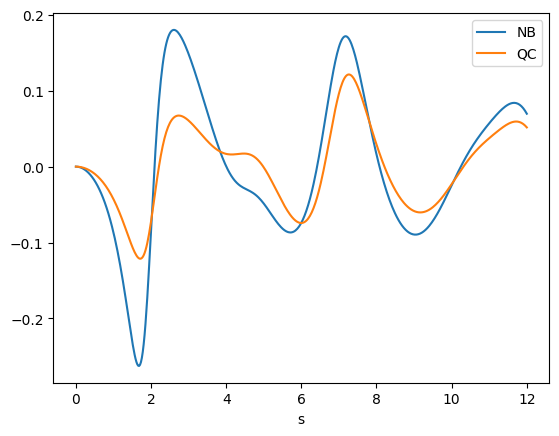

In [10]:
NB_late_all = np.array((NB_s2_late, NB_s3_late, NB_s4_late))
NB_traj_late_times = np.mean(NB_late_all, axis=0)
print(NB_traj_late_times.shape)

QC_late_all = np.array((QC_s2_late, QC_s3_late, QC_s4_late))
QC_traj_late_times = np.mean(QC_late_all, axis=0)
print(QC_traj_late_times.shape)

plt.figure()
plt.plot(traj_s, NB_traj_late_times, label="NB")
plt.plot(traj_s, QC_traj_late_times, label="QC")
plt.legend()
plt.xlabel("s")
plt.show()

In [11]:
print(traj_s.max())
print(traj_s.min())
print(s_simu.max())
print(s_simu.min())

# traj_s_trunc = traj_s[np.where(traj_s < s_simu.max())[0]]
# print(len(traj_s_trunc))
# print((s_simu[1]-s_simu[0]))
# print(traj_s[1]-traj_s[0])

12.0
0.0
9.9873
0.0


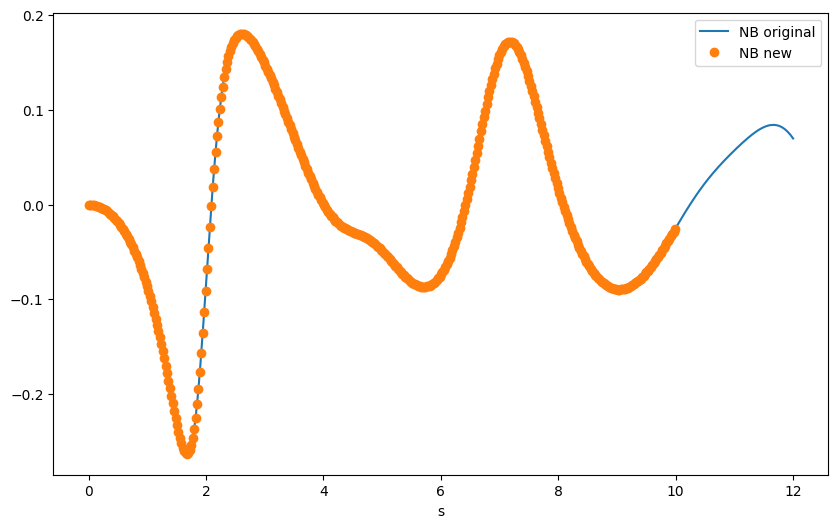

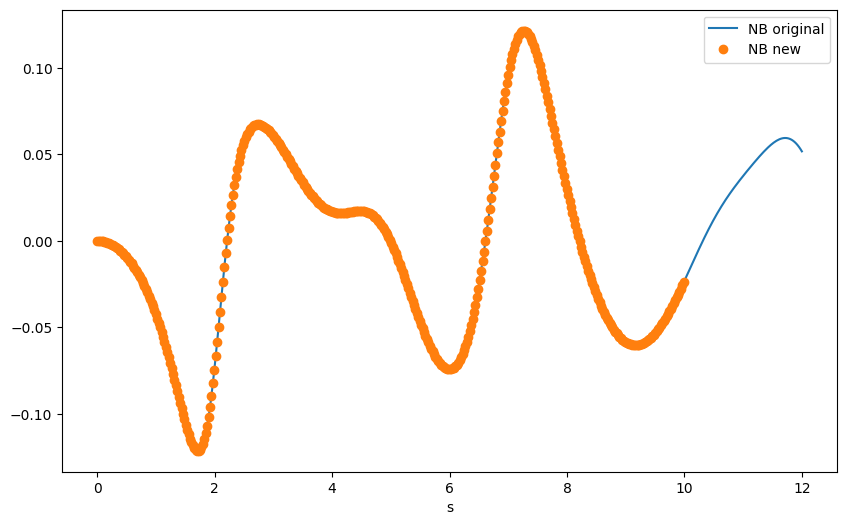

In [12]:
from scipy.interpolate import interp1d


# Original non-linear array (sine wave with 50 points)
NB_late_new = NB_traj_late_times
QC_late_new = QC_traj_late_times

# Target array length (we want 100 points in the resampled array)
array2_length = len(s_simu)

# Create an interpolation function for array1 based on its index
x_original = traj_s # Normalized indices for array1
NB_interp_func = interp1d(x_original, NB_late_new, kind='cubic')  # Cubic interpolation
QC_interp_func = interp1d(x_original, QC_late_new, kind='cubic')

# Interpolate array1 to match the length of array2
x_target = s_simu # Normalized indices for target length
QC_late_resampled = QC_interp_func(x_target)
NB_late_resampled = NB_interp_func(x_target)

# Plot the original and resampled arrays
plt.figure(figsize=(10, 6))
plt.plot(traj_s, NB_traj_late_times, "-", label="NB original")
plt.plot(s_simu, NB_late_resampled, "o", label="NB new")
plt.xlabel("s")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(traj_s, QC_traj_late_times, "-", label="NB original")
plt.plot(s_simu, QC_late_resampled, "o", label="NB new")
plt.xlabel("s")
plt.legend()
plt.show()


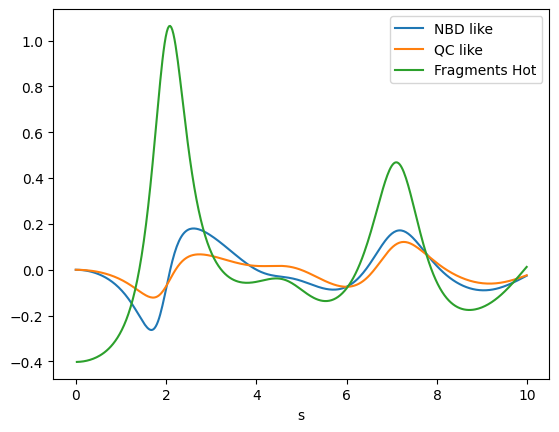

In [75]:
plt.figure()
plt.plot(s_simu, NB_late_resampled, label="NBD like")
plt.plot(s_simu, QC_late_resampled, label="QC like")
plt.plot(s_simu, frag_simu, label="Fragments Hot")
# plt.plot(s_simu, frag_alt, label="Fragments other?")
plt.xlabel("s")
plt.legend()
plt.show()

In [13]:
from scipy.io import savemat

NB_late_dict = {"NB_late_line": NB_late_resampled}
QC_late_dict = {"QC_late_line": QC_late_resampled}

savemat("C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\NB_late.mat", NB_late_dict)
savemat("C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\QC_late.mat", QC_late_dict)

In [13]:
s2_conv_all_trajs = np.concatenate([QC_s2_dI_conv_all, NB_s2_dI_conv_all])
print(s2_conv_all_trajs.shape)

s3_conv_all_trajs = np.concatenate([QC_s3_dI_conv_all, NB_s3_dI_conv_all])
print(s3_conv_all_trajs.shape)

s4_conv_all_trajs = np.concatenate([QC_s4_dI_conv_all, NB_s4_dI_conv_all])
print(s4_conv_all_trajs.shape)

(100,)
(78,)
(56,)


## Trying to Properly Get Std of Trajectories

(2800,)


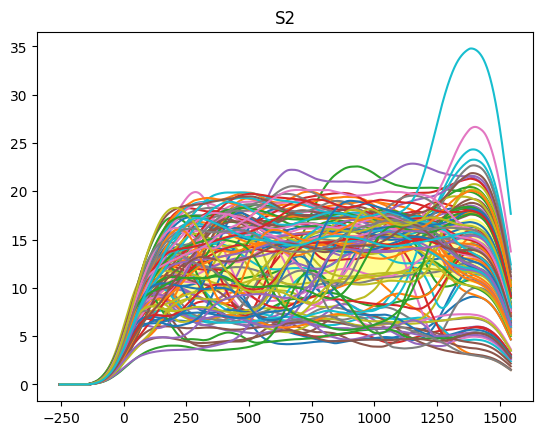

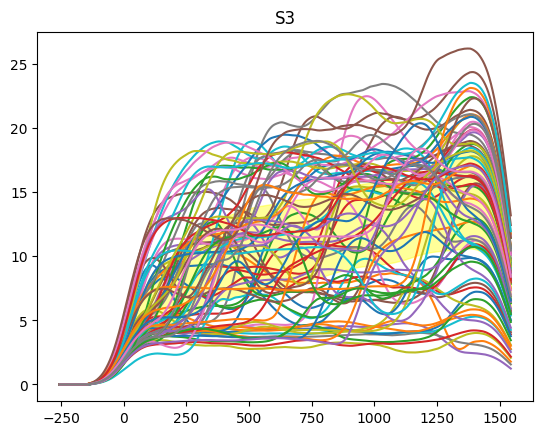

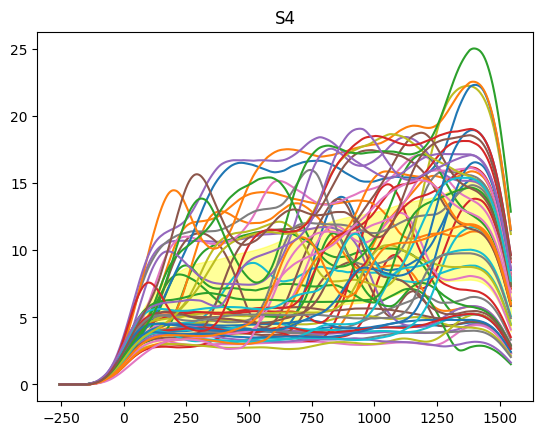

In [14]:
s2_dI_conv_all_1d = []
plt.figure()
for array in s2_conv_all_trajs:
    array = array.T
    line = np.sum(np.abs(array[traj_indices]), axis=0)
    #print(line.shape)
    s2_dI_conv_all_1d.append(line)
    plt.plot(time_vals, line)

s2_dI_conv_all_1d = np.array(s2_dI_conv_all_1d)
s2_dI_mean = np.mean(s2_dI_conv_all_1d, axis=0)
QC_s2_dI_std = np.std(s2_dI_conv_all_1d[:QC_s2_weight], axis=0)
NB_s2_dI_std = np.std(s2_dI_conv_all_1d[QC_s2_weight:], axis=0)
s2_dI_std = np.sqrt((QC_s2_dI_std*QC_s2_weight/(QC_s2_weight + NB_s2_weight))**2 + (NB_s2_dI_std*NB_s2_weight/(QC_s2_weight + NB_s2_weight))**2)
print(s2_dI_std.shape)
plt.fill_between(time_vals, s2_dI_mean-s2_dI_std, s2_dI_mean+s2_dI_std, color='yellow', alpha=0.4)
plt.title("S2")
plt.show()

s3_dI_conv_all_1d = []
plt.figure()
for array in s3_conv_all_trajs:
    array = array.T
    line = np.sum(np.abs(array[traj_indices]), axis=0)
    #print(line.shape)
    s3_dI_conv_all_1d.append(line)
    plt.plot(time_vals, line)

s3_dI_conv_all_1d = np.array(s3_dI_conv_all_1d)
s3_dI_mean = np.mean(s3_dI_conv_all_1d, axis=0)
QC_s3_dI_std = np.std(s2_dI_conv_all_1d[:QC_s3_weight], axis=0)
NB_s3_dI_std = np.std(s2_dI_conv_all_1d[QC_s3_weight:], axis=0)
s3_dI_std = np.sqrt((QC_s3_dI_std*QC_s3_weight/(QC_s3_weight + NB_s3_weight))**2 + (NB_s3_dI_std*NB_s3_weight/(QC_s3_weight + NB_s3_weight))**2)
plt.fill_between(time_vals, s3_dI_mean-s3_dI_std, s3_dI_mean+s3_dI_std, color='yellow', alpha=0.4)
plt.title("S3")
plt.show()

s4_dI_conv_all_1d = []
plt.figure()
for array in s4_conv_all_trajs:
    array = array.T
    line = np.sum(np.abs(array[traj_indices]), axis=0)
    #print(line.shape)
    s4_dI_conv_all_1d.append(line)
    plt.plot(time_vals, line)

s4_dI_conv_all_1d = np.array(s4_dI_conv_all_1d)
s4_dI_mean = np.mean(s4_dI_conv_all_1d, axis=0)
QC_s4_dI_std = np.std(s2_dI_conv_all_1d[:QC_s4_weight], axis=0)
NB_s4_dI_std = np.std(s2_dI_conv_all_1d[QC_s4_weight:], axis=0)
s4_dI_std = np.sqrt((QC_s4_dI_std*QC_s4_weight/(QC_s4_weight + NB_s4_weight))**2 + (NB_s4_dI_std*NB_s4_weight/(QC_s4_weight + NB_s4_weight))**2)
plt.fill_between(time_vals, s4_dI_mean-s4_dI_std, s4_dI_mean+s4_dI_std, color='yellow', alpha=0.4)
plt.title("S4")
plt.show()
# plt.figure()
# plt.plot(time_vals, QC_s2_dI_conv_all_1d)
# plt.show()

# print(QC_s2_dI_conv.shape)

## Plot CI vs t0

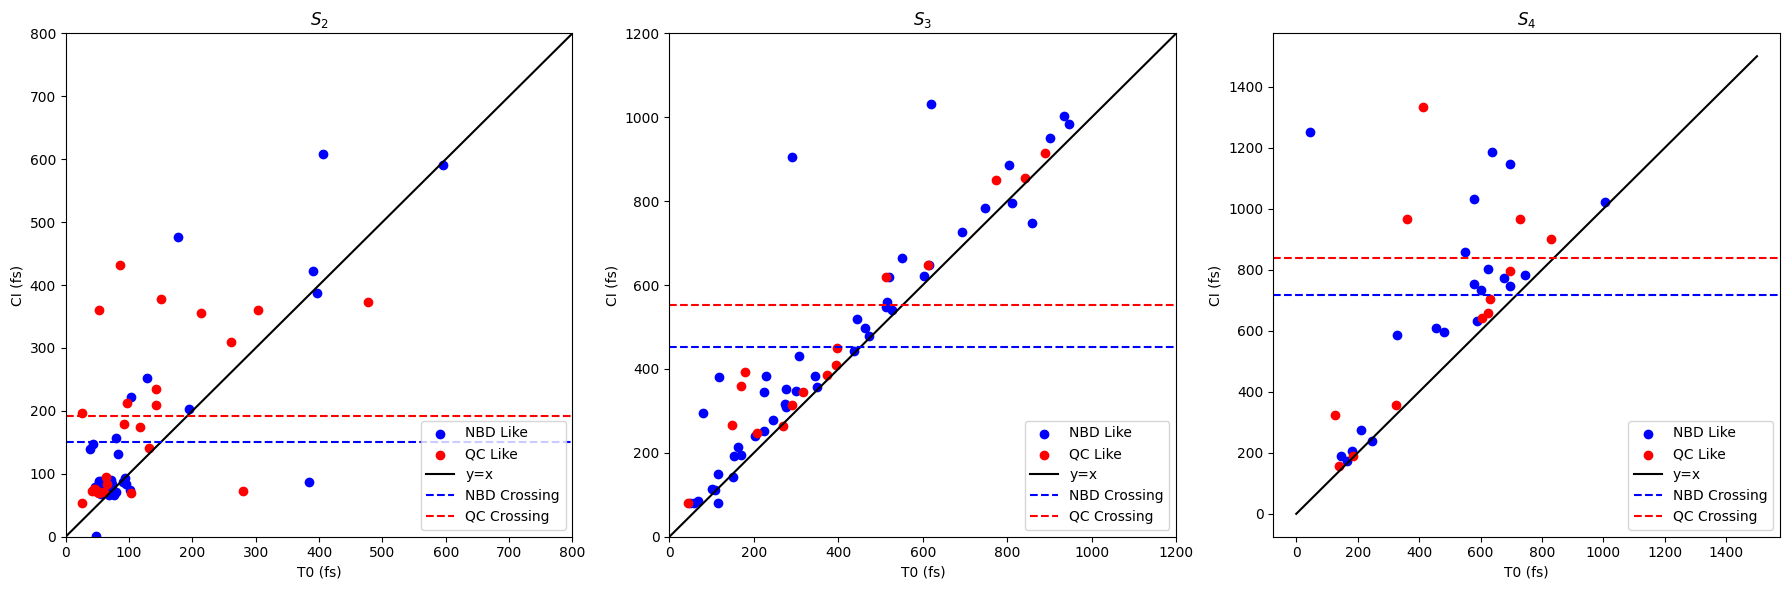

In [15]:
x_vals = np.linspace(0,1500,100)

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.scatter(NB_s2_t0s, NB_s2_CIs, color="blue", label="NBD Like")
plt.scatter(QC_s2_t0s, QC_s2_CIs, color="red", label="QC Like")
plt.plot(x_vals, x_vals, color="k", label="y=x")
plt.axhline(y=NB_s2_CI, color="blue", label="NBD Crossing", linestyle="--")
plt.axhline(y=QC_s2_CI, color="red", label="QC Crossing", linestyle='--')
plt.xlabel("T0 (fs)")
plt.ylabel("CI (fs)")
plt.title(r'$S_{2}$')
plt.xlim(0,800)
plt.ylim(0,800)
plt.legend(loc="lower right")

plt.subplot(1,3,2)
plt.scatter(NB_s3_t0s, NB_s3_CIs, color="blue", label="NBD Like")
plt.scatter(QC_s3_t0s, QC_s3_CIs, color="red", label="QC Like")
plt.plot(x_vals, x_vals, color="k", label="y=x")
plt.axhline(y=NB_s3_CI, color="blue", label="NBD Crossing", linestyle="--")
plt.axhline(y=QC_s3_CI, color="red", label="QC Crossing", linestyle='--')
plt.xlabel("T0 (fs)")
plt.ylabel("CI (fs)")
plt.title(r'$S_{3}$')
plt.xlim(0,1200)
plt.ylim(0,1200)
plt.legend(loc="lower right")

plt.subplot(1,3,3)
plt.scatter(NB_s4_t0s, NB_s4_CIs, color="blue", label="NBD Like")
plt.scatter(QC_s4_t0s, QC_s4_CIs, color="red", label="QC Like")
plt.plot(x_vals, x_vals, color="k", label="y=x")
plt.axhline(y=NB_s4_CI, color="blue", label="NBD Crossing", linestyle="--")
plt.axhline(y=QC_s4_CI, color="red", label="QC Crossing", linestyle='--')
plt.xlabel("T0 (fs)")
plt.ylabel("CI (fs)")
plt.title(r'$S_{4}$')
# plt.xlim(0,1500)
# plt.ylim(0,1500)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [16]:
dI_I_all_traj = np.mean((QC_s2_dI, QC_s3_dI, QC_s4_dI, NB_s2_dI, NB_s3_dI, NB_s4_dI), axis=0)
dI_I_weighted_traj_conv = np.sum(((QC_s2_dI_conv*QC_s2_weight), (NB_s2_dI_conv*NB_s2_weight), 
                             (QC_s3_dI_conv*QC_s3_weight), (NB_s3_dI_conv*NB_s3_weight),
                             (QC_s4_dI_conv*QC_s4_weight), (NB_s4_dI_conv*NB_s4_weight)), axis=0)/204
dI_I_weighted_traj = np.sum(((QC_s2_dI*QC_s2_weight), (NB_s2_dI*NB_s2_weight), 
                             (QC_s3_dI*QC_s3_weight), (NB_s3_dI*NB_s3_weight),
                             (QC_s4_dI*QC_s4_weight), (NB_s4_dI*NB_s4_weight)), axis=0)/204
dI_I_all_traj_conv = np.mean((QC_s2_dI_conv, QC_s3_dI_conv, QC_s4_dI_conv, NB_s2_dI_conv, NB_s3_dI_conv, NB_s4_dI_conv), axis=0)
dI_I_all_traj_feat1 = np.sum(np.abs(dI_I_all_traj[traj_indices]), axis=0)
dI_I_all_traj_feat1_conv = np.sum(np.abs(dI_I_all_traj_conv[traj_indices]), axis=0)
print(dI_I_all_traj.shape)
print(dI_I_all_traj_feat1.shape)

fit_NBD = 59.2
fit_QC = 16.9


s2_weighted = np.sum(((QC_s2_dI_conv*QC_s2_weight), (NB_s2_dI_conv*NB_s2_weight)), axis=0)/(QC_s2_weight+NB_s2_weight)
dI_I_s2_feat1 = np.sum(np.abs(s2_weighted[traj_indices]), axis=0)
dI_I_s2_feat1_conv = np.sum(np.abs(s2_weighted[traj_indices]), axis=0)
print(dI_I_s2_feat1.shape)

s2_all = np.mean((NB_s2_dI, QC_s2_dI), axis=0)
s2_all_fitting_weight = np.mean((NB_s2_dI*fit_NBD, QC_s2_dI*fit_QC), axis=0)/(fit_NBD+fit_QC)
s2_all_conv = np.mean((NB_s2_dI_conv, QC_s2_dI_conv), axis=0)
s2_all_conv_fitting_weight = np.sum((NB_s2_dI_conv*fit_NBD, QC_s2_dI_conv*fit_QC), axis=0)/(fit_NBD+fit_QC)
dI_I_s2_fit_feat1 = np.sum(np.abs(s2_all_conv_fitting_weight[traj_indices]), axis=0)

s3_weighted = np.sum(((QC_s3_dI_conv*QC_s3_weight), (NB_s3_dI_conv*NB_s3_weight)), axis=0)/(QC_s3_weight+NB_s3_weight)
dI_I_s3_feat1 = np.sum(np.abs(s3_weighted[traj_indices]), axis=0)
dI_I_s3_feat1_conv = np.sum(np.abs(s3_weighted[traj_indices]), axis=0)
print(dI_I_s3_feat1.shape)

s3_all = np.mean((NB_s3_dI, QC_s3_dI), axis=0)
s3_all_fitting_weight = np.mean((NB_s3_dI*fit_NBD, QC_s3_dI*fit_QC), axis=0)/(fit_NBD+fit_QC)
s3_all_conv = np.mean((NB_s3_dI_conv, QC_s3_dI_conv), axis=0)
s3_all_conv_fitting_weight = np.sum((NB_s3_dI_conv*fit_NBD, QC_s3_dI_conv*fit_QC), axis=0)/(fit_NBD+fit_QC)
dI_I_s3_fit_feat1 = np.sum(np.abs(s3_all_conv_fitting_weight[traj_indices]), axis=0)

s4_weighted = np.sum(((QC_s4_dI_conv*QC_s4_weight), (NB_s4_dI_conv*NB_s4_weight)), axis=0)/(QC_s4_weight+NB_s4_weight)
dI_I_s4_feat1 = np.sum(np.abs(s4_weighted[traj_indices]), axis=0)
dI_I_s4_feat1_conv = np.sum(np.abs(s4_weighted[traj_indices]), axis=0)

s4_all = np.mean((NB_s4_dI, QC_s4_dI), axis=0)
s4_all_fitting_weight = np.mean((NB_s4_dI*fit_NBD, QC_s4_dI*fit_QC), axis=0)/(fit_NBD+fit_QC)
s4_all_conv = np.mean((NB_s4_dI_conv, QC_s4_dI_conv), axis=0)
s4_all_conv_fitting_weight = np.sum((NB_s4_dI_conv*fit_NBD, QC_s4_dI_conv*fit_QC), axis=0)/(fit_NBD+fit_QC)
dI_I_s4_fit_feat1 = np.sum(np.abs(s4_all_conv_fitting_weight[traj_indices]), axis=0)


(500, 2800)
(2800,)
(2800,)
(2800,)


## Plot 2D dI/I for all Trajectories

(500, 2800)
(500, 2800)


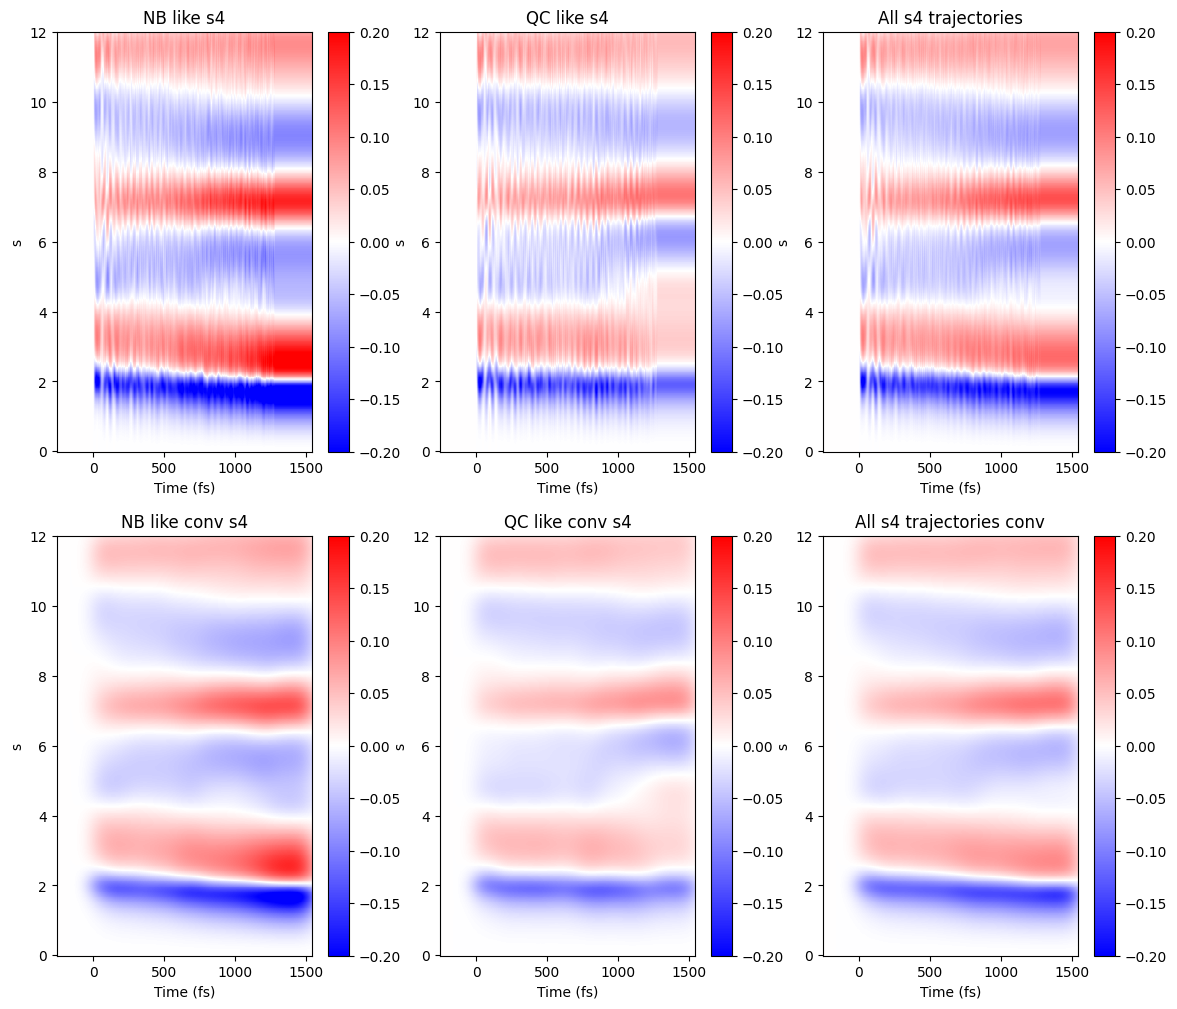

In [17]:
plt.figure(figsize=(14,12))
plt.subplot(2,3,1)
plt.pcolor(time_vals, NB_s2_traj["0107"]["s"], NB_s4_dI, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.colorbar()
plt.title("NB like s4")

plt.subplot(2,3,2)
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], QC_s4_dI, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.colorbar()
plt.title("QC like s4")

s4_all = np.mean((NB_s4_dI, QC_s4_dI), axis=0)
print(s4_all.shape)
plt.subplot(2,3,3)
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], s4_all, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.title("All s4 trajectories")
plt.colorbar()

plt.subplot(2,3,4)
plt.pcolor(time_vals, NB_s2_traj["0107"]["s"], NB_s4_dI_conv, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.colorbar()
plt.title("NB like conv s4")

plt.subplot(2,3,5)
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], QC_s4_dI_conv, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.colorbar()
plt.title("QC like conv s4")

s4_all_conv = np.mean((NB_s4_dI_conv, QC_s4_dI_conv), axis=0)
print(s4_all.shape)
plt.subplot(2,3,6)
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], s4_all_conv, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.title("All s4 trajectories conv")
plt.colorbar()
plt.show()

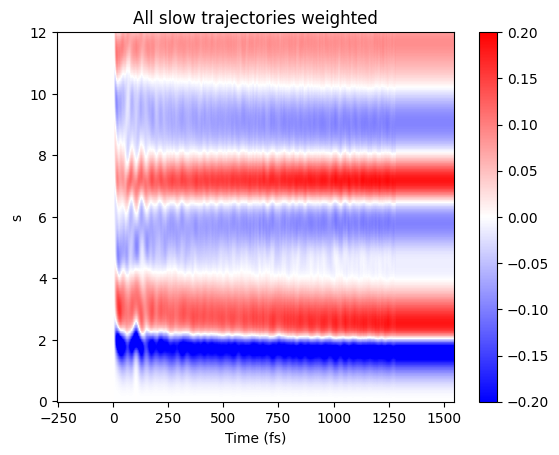

In [18]:
plt.figure()
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], dI_I_weighted_traj, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.title("All slow trajectories weighted")
plt.colorbar()
plt.show()

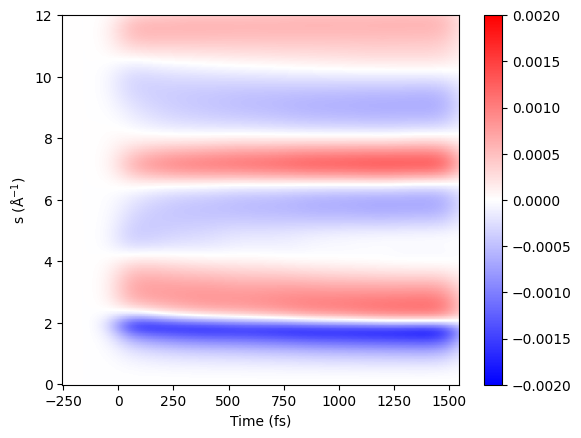

In [19]:
plt.figure()
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], dI_I_all_traj_conv/100, cmap='bwr')
plt.clim(-0.002, 0.002)
plt.xlabel("Time (fs)")
plt.ylabel("s ($\mathrm{\AA}^{-1}$)")
# plt.title("All Trajectories conv")
plt.colorbar()
plt.show()

C:\Users\laure\AppData\Local\Temp\ipykernel_12132\1871513724.py:5: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\laure\AppData\Local\Temp\ipykernel_12132\1871513724.py:11: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


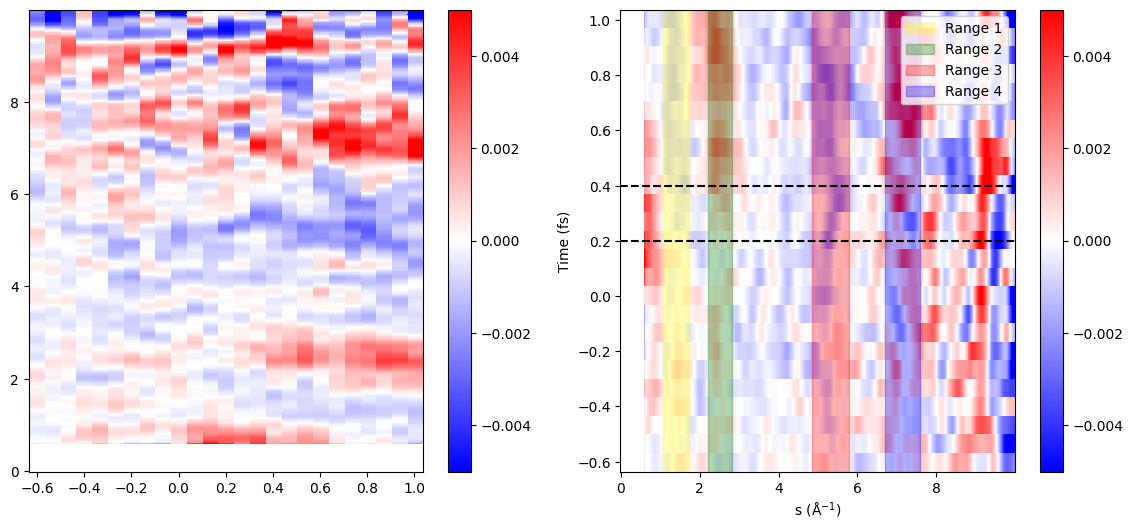

In [20]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.pcolor(time_exp, s_simu, dI_I_smooth, cmap='bwr')
plt.clim(-0.005,0.005)
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolor(s_simu, time_exp, dI_I_smooth.T, cmap='bwr')
plt.clim(-0.005, 0.005)
plt.xlabel(f"s {inv_angs}")
plt.colorbar()
plt.ylabel("Time (fs)")

# Overlay the shaded regions for each range
plt.axvspan(min_s1, max_s1, color='yellow', alpha=0.3, label='Range 1')  # shade range 1
plt.axvspan(min_s2, max_s2, color='green', alpha=0.3, label='Range 2')  # shade range 2
plt.axvspan(min_s3, max_s3, color='red', alpha=0.3, label='Range 3')    # shade range 3
plt.axvspan(min_s4, max_s4, color='blue', alpha=0.3, label='Range 4')   # shade range 4
plt.axhline(y=0.2, color='k', linestyle='--')
plt.axhline(y=0.4, color='k',  linestyle='--')

# Add a legend
plt.legend(loc='upper right')

plt.show()

## Plot Time Lineouts

In [21]:
def normalize(data_set, max_val='Auto', min_val='Auto'):
    if max_val == 'Auto':
        normalized_data = (data_set - np.nanmin(data_set))/(np.nanmax(data_set) - np.nanmin(data_set))
        std_factor = 1/(np.nanmax(data_set) - np.nanmin(data_set))
    elif isinstance(max_val, float) and isinstance(min_val, float):
        normalized_data = (data_set - min_val)/(max_val - min_val)
        std_factor = 1/(max_val-min_val)
    return normalized_data, std_factor

In [22]:
#print(dI_I_boot.shape)
dI_I_ave = np.nanmean(dI_I_boot, axis=2).T
#print(dI_I_ave)
dI_I_feat1 = np.nansum(np.abs(dI_I_boot[exp_indices][:]), axis=0)
#print(dI_I_feat1.shape)
dI_I_feat1_mean = np.nanmean(dI_I_feat1[:-4], axis=1)
dI_I_feat1_err = np.nanstd(dI_I_feat1[:-4], axis=1)
#print(dI_I_feat1_err)

min_val = np.nanmean(dI_I_feat1_mean[np.where((time_exp > -0.3) & (time_exp < 0.0))[0]])
max_val = np.nanmean(dI_I_feat1_mean[np.where((time_exp > 0.8) & (time_exp < 1.00))[0]])

#print(min_val, max_val)
dI_I_feat1_norm, std_factor = normalize(dI_I_feat1_mean, max_val=max_val, min_val=min_val)
dI_I_feat1_err_norm = dI_I_feat1_err*std_factor
#print(dI_I_feat1_norm)

electronic_idx = np.where((s_simu > 0.6) & (s_simu < 1.1))[0]
dI_I_electronic = np.nansum(np.abs(dI_I_boot[electronic_idx][:]), axis=0)
dI_I_elec_mean = np.nanmean(dI_I_electronic[:-4], axis=1)
dI_I_elec_err = np.nanstd(dI_I_electronic[:-4], axis=1)

e_min = np.nanmean(dI_I_elec_mean[np.where((time_exp > -0.3) & (time_exp < 0.0))[0]])
e_max = np.nanmean(dI_I_elec_mean[np.where((time_exp > 0.1) & (time_exp < 0.3))[0]])
dI_I_elec_norm, std_factor = normalize(dI_I_elec_mean, max_val=e_max, min_val=e_min)
dI_I_elec_err_norm = dI_I_elec_err*std_factor

#print(time_new.shape)

### Gaussian and erf Fit 

Optimized parameters: 
 a1 = 0.9435  
 sigma = 67.24 
 FWHM = 1.58e+02       
 tau = 216.11 
 t0 = 0.00 
 offset = -0.01


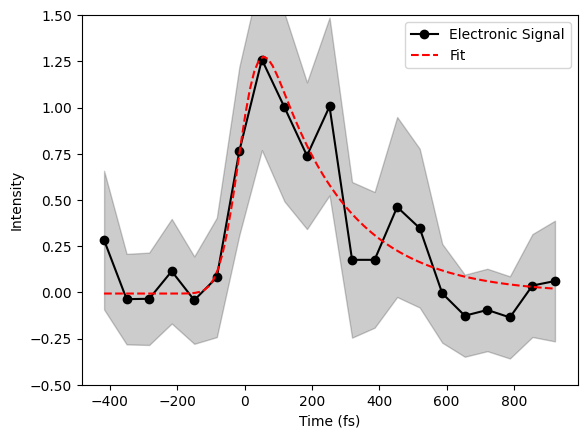

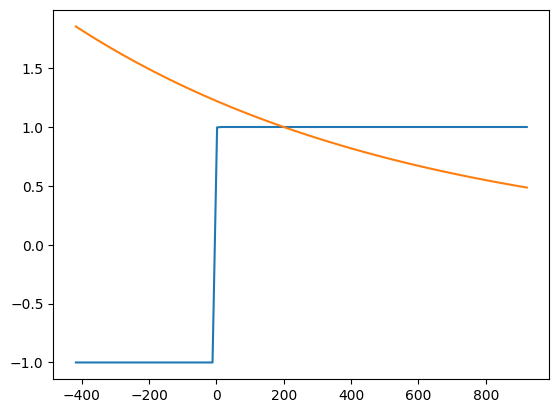

In [23]:


# Define the function I(t, tau) based on the equation
def model(t, a, sigma, tau, c):
    term1 = (sigma / (2 * tau)) - (t - c) / sigma
    term2 = ((sigma / (2 * tau)) ** 2) - (t - c) / tau
    return a * (1 - erf(term1)) * np.exp(term2)

def model_test(t, a, sigma, tau2, c, b):
    term1 = -(t - c) / sigma
    term2 =  -(t - c) / tau2
    return a * erf(term1)* np.exp(term2) + b

def model_2(t, a, sigma, tau, c):
    term1 = (t - c) / sigma
    term2 =  -(t - c) / tau
    return a * (erf(term1)) * np.exp(term2)

def erf_function(t, sigma, c):
    fit = (1-erf(-(t-c)/(sigma)))
    return fit

def exp_function(t, tau2, c):
    fit = np.exp(-(t-c)/tau2)
    return fit

def fit_model(t, a, sigma, tau2, c, b):
    combined_fit = a* (erf_function(t, sigma, c)) * (exp_function(t, tau2, c)) + b
    return combined_fit

# Generate synthetic data (adjust parameters as needed)
t_exp = time_new*1000
y_exp = dI_I_elec_norm

# Initial guesses for the fit parameters
p0 = [1.5, 50, 60, 100, 0]  # a, sigma, tau, center, offset
bounds = ([0, 0, 0, -50], [5, 100, 500, 150])

# Fit the data using curve_fit
popt_exp, pcov_exp = curve_fit(fit_model, t_exp[:], y_exp[:], p0=p0)


# Print the optimized parameters 
print(f"Optimized parameters: \n a1 = {popt_exp[0]:.4f}  \n sigma = {popt_exp[1]:.2f} \n FWHM = {2.355*popt_exp[1]:.3} \
      \n tau = {popt_exp[2]:.2f} \n t0 = {popt_exp[3]:.2f} \n offset = {popt_exp[4]:.2f}")
x_new = np.linspace(np.min(t_exp), np.max(t_exp), 100)
fit_line =  fit_model(x_new, *popt_exp)
exp_line = popt_exp[0] * exp_function(x_new, popt_exp[2], popt_exp[3]) + popt_exp[4]
erf_line = popt_exp[0] * erf_function(x_new, popt_exp[1], popt_exp[3]) + popt_exp[4]
test = erf((x_new))
test2 = np.exp(-(x_new-200)/1000)


plt.figure()
plt.plot(t_exp, y_exp, "-o", color="k", label="Electronic Signal")
plt.fill_between(t_exp, y_exp-dI_I_elec_err_norm, y_exp+dI_I_elec_err_norm, color='k', alpha=0.2)
plt.plot(x_new, fit_line, "--", label="Fit", color="red")
# plt.plot(x_new, exp_line, "--", color="green", label="exp")
# plt.plot(x_new, erf_line, "--", color="blue", label="erf")
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.legend()
plt.ylim(-0.5, 1.5)
plt.show()

plt.figure()
plt.plot(x_new, test)
plt.plot(x_new, test2)
plt.show()

Optimized parameters: 
 a = 0.5538 
 sigma = 277.35 
 FWHM = 6.53e+02       
 t0 = 393.09 
 offset = -0.02


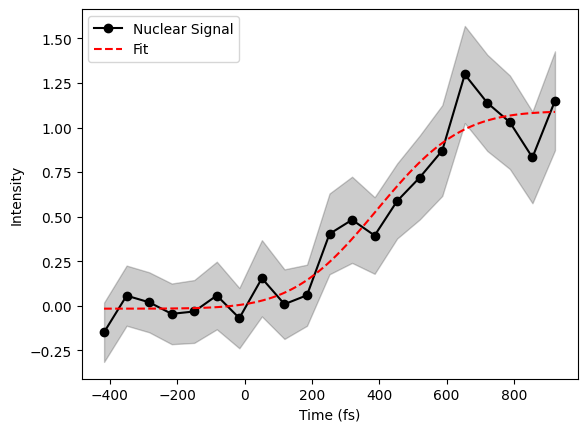

In [26]:
# # Define the function I(t, tau) based on the equation
# def model(t, a, sigma, tau, c):
#     term1 = (sigma / (2 * tau)) - (t - c) / sigma
#     term2 = ((sigma / (2 * tau)) ** 2) - (t - c) / tau
#     return a * (1 - erf(term1)) * np.exp(term2)

# def model_new(t, a, sigma, tau1, tau2, c):
#     term1 = (sigma / (2 * tau1)) - (t - c) / sigma
#     term2 =  -(t - c) / tau2
#     return a * (1 - erf(term1)) * np.exp(term2)

# def model_2(t, a, sigma, tau, c):
#     term1 = (t - c) / sigma
#     term2 =  -(t - c) / tau
#     return a * (erf(term1)) * np.exp(term2)

# def erf_function(t, sigma, tau, c):
#     term1 = (sigma/(2*tau))-(t-c)/sigma
#     return (1-erf(term1))

# def exp_function(t, tau2, c):
#     fit = np.exp(-(t-c)/tau2)
#     return fit
# def erf_function(t, a, sigma, c, b):
#     fit = a*(erf(-(t-c)/(sigma/np.sqrt(2*np.log10(2)))*np.sqrt(2)))+b
#     return fit
# def fit_model(t, a, sigma, tau, tau2, c):
#     combined_fit = a * erf_function(t, sigma, tau, c) * exp_function(t, tau2, c)
#     return combined_fit

def erf_function(t, a, sigma, c, b):
    fit = a* (1-erf(-(t-c)/(sigma))) + b
    return fit

# Generate synthetic data (adjust parameters as needed)
t_exp = time_new*1000
y_exp = dI_I_feat1_norm

# Initial guesses for the fit parameters
p0 = [1.0, 150, 500, 0] # a, sigma, tau, c
bounds = ([0, 0, 0, -0.01], [1.5, 100, 300, 0])

# Fit the data using curve_fit
popt_exp, pcov_exp = curve_fit(erf_function, t_exp, y_exp, p0=p0)

# Print the optimized parameters
print(f"Optimized parameters: \n a = {popt_exp[0]:.4f} \n sigma = {popt_exp[1]:.2f} \n FWHM = {2.355*popt_exp[1]:.3} \
      \n t0 = {popt_exp[2]:.2f} \n offset = {popt_exp[3]:.2f}")
x_new = np.linspace(np.min(t_exp), np.max(t_exp), 100)
nuc_fit_line =  erf_function(x_new, *popt_exp)
# exp_line = popt_exp[0] * exp_function(x_new, popt_exp[3], popt_exp[4])
# erf_line = popt_exp[0] * erf_function(x_new, popt_exp[1], popt_exp[2], popt_exp[4])
# Plot the data and the fit
# plt.subplot(1,2,1)
# plt.scatter(t_data, y_data, label="Data", s=10)
# plt.plot(t_data, model(t_data, *popt), label="Fit", color="red")
# plt.legend()
plt.figure()
plt.plot(t_exp, y_exp, "-o", color="k", label="Nuclear Signal")
plt.fill_between(t_exp, y_exp-dI_I_feat1_err_norm, y_exp+dI_I_feat1_err_norm, color='k', alpha=0.2)
plt.plot(x_new, nuc_fit_line, '--', label="Fit", color="red")
# plt.plot(x_new, exp_line, "--", color="green")
# plt.plot(x_new, erf_line, "--", color="blue")
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.legend()
plt.show()


In [27]:
1/np.sqrt(2*np.log10(2))*np.sqrt(2)

1.822615728804995

In [28]:
print(f"tau = {2.355*popt_exp[1]}")
print(f"tau = {2.355*popt_exp[2]}")

tau = 653.1507594988698
tau = 925.7274639359438


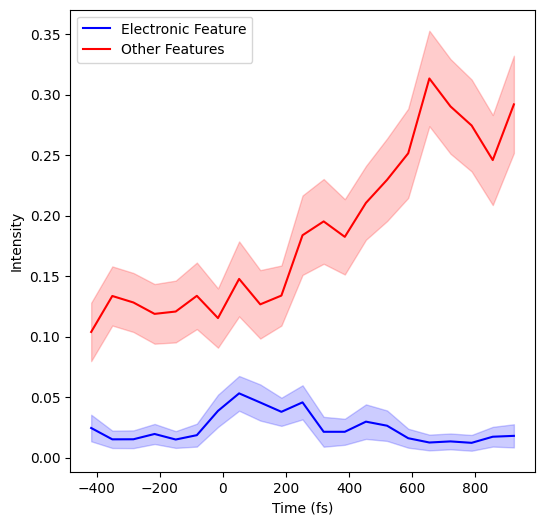

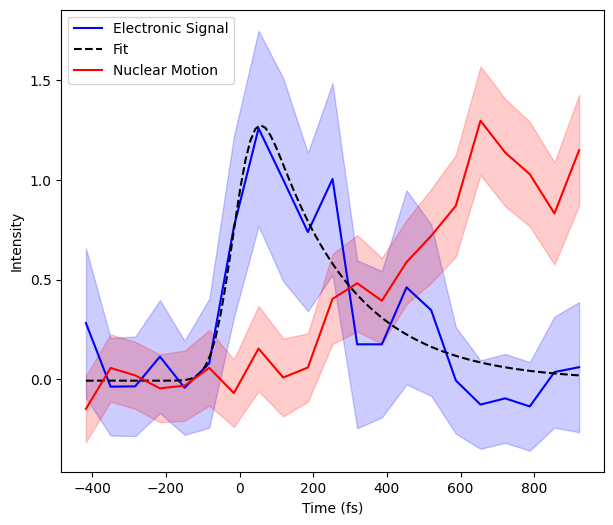

In [29]:
plt.figure(figsize=(6, 6))
# plt.subplot(1,2,1)
plt.plot(time_new*1000, dI_I_elec_mean, color="blue", label="Electronic Feature")
plt.fill_between(time_new*1000, dI_I_elec_mean-dI_I_elec_err, dI_I_elec_mean+dI_I_elec_err, color='blue', alpha=0.2)
plt.plot(time_new*1000, dI_I_feat1_mean, color="red", label="Other Features")
plt.fill_between(time_new*1000, dI_I_feat1_mean-dI_I_feat1_err, dI_I_feat1_mean+dI_I_feat1_err, color='red', alpha=0.2)
plt.legend()
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.show()

# plt.subplot(1,2,2)
plt.figure(figsize=(7,6))
plt.plot(time_new*1000, dI_I_elec_norm, color="blue", label="Electronic Signal")
plt.fill_between(time_new*1000, dI_I_elec_norm-dI_I_elec_err_norm, dI_I_elec_norm+dI_I_elec_err_norm, color='blue', alpha=0.2)
plt.plot(x_new, fit_line, "--", color='k', label="Fit")
plt.plot(time_new*1000, dI_I_feat1_norm, color="red", label="Nuclear Motion")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err_norm, dI_I_feat1_norm+dI_I_feat1_err_norm, color='red', alpha=0.2)
plt.legend()
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.show()

In [30]:
NB_s2_min = np.nanmean(NB_s2_feat_1_conv[np.where((time_vals < -100))[0]])
NB_s2_max = np.nanmean(NB_s2_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
NB_s2_feat1_norm, NB_s2_err_factor = normalize(NB_s2_feat_1_conv, max_val=NB_s2_max, min_val=NB_s2_min)
print(NB_s2_feat1_norm.shape)
QC_s2_min = np.nanmean(QC_s2_feat_1_conv[np.where((time_vals < -100))[0]])
QC_s2_max = np.nanmean(QC_s2_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
QC_s2_feat1_norm, QC_s2_err_factor = normalize(QC_s2_feat_1_conv, max_val=QC_s2_max, min_val=QC_s2_min)
print(QC_s2_feat1_norm.shape)

s2_weighted_min = np.nanmean(dI_I_s2_feat1_conv[np.where((time_vals < -100))[0]])
s2_weighted_max = np.nanmean(dI_I_s2_feat1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
dI_I_s2_norm, dI_I_s2_err_factor = normalize(dI_I_s2_feat1_conv, max_val=s2_weighted_max, min_val=s2_weighted_min)
dI_I_s2_norm_err = s2_dI_std*dI_I_s2_err_factor
s2_fit_min = np.nanmean(dI_I_s2_fit_feat1[np.where((time_vals < -100))[0]])
s2_fit_max = np.nanmean(dI_I_s2_fit_feat1[np.where((time_vals > 800) & (time_vals < 1000))[0]])
dI_I_s2_fit_norm, _ = normalize(dI_I_s2_fit_feat1, max_val=s2_fit_max, min_val=s2_fit_min)

NB_s3_min = np.nanmean(NB_s3_feat_1_conv[np.where((time_vals < -100))[0]])
NB_s3_max = np.nanmean(NB_s3_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
NB_s3_feat1_norm, NB_s3_err_factor = normalize(NB_s3_feat_1_conv, max_val=NB_s3_max, min_val=NB_s3_min)
print(NB_s3_feat1_norm.shape)

QC_s3_min = np.nanmean(QC_s3_feat_1_conv[np.where((time_vals < -100))[0]])
QC_s3_max = np.nanmean(QC_s3_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
QC_s3_feat1_norm, QC_s3_err_factor = normalize(QC_s3_feat_1_conv, max_val=QC_s3_max, min_val=QC_s3_min)

s3_weighted_min = np.nanmean(dI_I_s3_feat1_conv[np.where((time_vals < -100))[0]])
s3_weighted_max = np.nanmean(dI_I_s3_feat1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
dI_I_s3_norm, dI_I_s3_err_factor = normalize(dI_I_s3_feat1_conv, max_val=s3_weighted_max, min_val=s3_weighted_min)
dI_I_s3_norm_err = s3_dI_std*dI_I_s3_err_factor
s3_fit_min = np.nanmean(dI_I_s3_fit_feat1[np.where((time_vals < -100))[0]])
s3_fit_max = np.nanmean(dI_I_s3_fit_feat1[np.where((time_vals > 800) & (time_vals < 1000))[0]])
dI_I_s3_fit_norm, _ = normalize(dI_I_s3_fit_feat1, max_val=s3_fit_max, min_val=s3_fit_min)

NB_s4_min = np.nanmean(NB_s4_feat_1_conv[np.where((time_vals < -100))[0]])
NB_s4_max = np.nanmean(NB_s4_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
NB_s4_feat1_norm, NB_s4_err_factor = normalize(NB_s4_feat_1_conv, max_val=NB_s4_max, min_val=NB_s4_min)
print(NB_s4_feat1_norm.shape)

QC_s4_min = np.nanmean(QC_s4_feat_1_conv[np.where((time_vals < -100))[0]])
QC_s4_max = np.nanmean(QC_s4_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
QC_s4_feat1_norm, QC_s4_err_factor = normalize(QC_s4_feat_1_conv, max_val=QC_s4_max, min_val=QC_s4_min)

s4_weighted_min = np.nanmean(dI_I_s4_feat1_conv[np.where((time_vals < -100))[0]])
s4_weighted_max = np.nanmean(dI_I_s4_feat1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
dI_I_s4_norm, dI_I_s4_err_factor = normalize(dI_I_s4_feat1_conv, max_val=s4_weighted_max, min_val=s4_weighted_min)
dI_I_s4_norm_err = s4_dI_std*dI_I_s4_err_factor
s4_fit_min = np.nanmean(dI_I_s4_fit_feat1[np.where((time_vals < -100))[0]])
s4_fit_max = np.nanmean(dI_I_s4_fit_feat1[np.where((time_vals > 800) & (time_vals < 1000))[0]])
dI_I_s4_fit_norm, _ = normalize(dI_I_s4_fit_feat1, max_val=s4_fit_max, min_val=s4_fit_min)

(2800,)
(2800,)
(2800,)
(2800,)


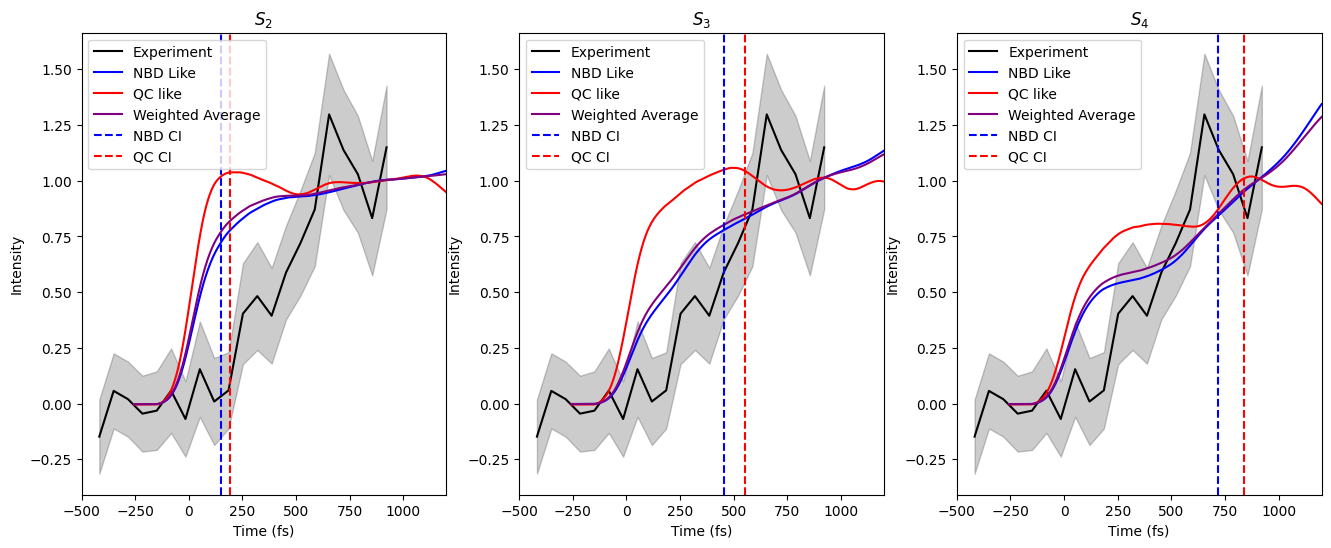

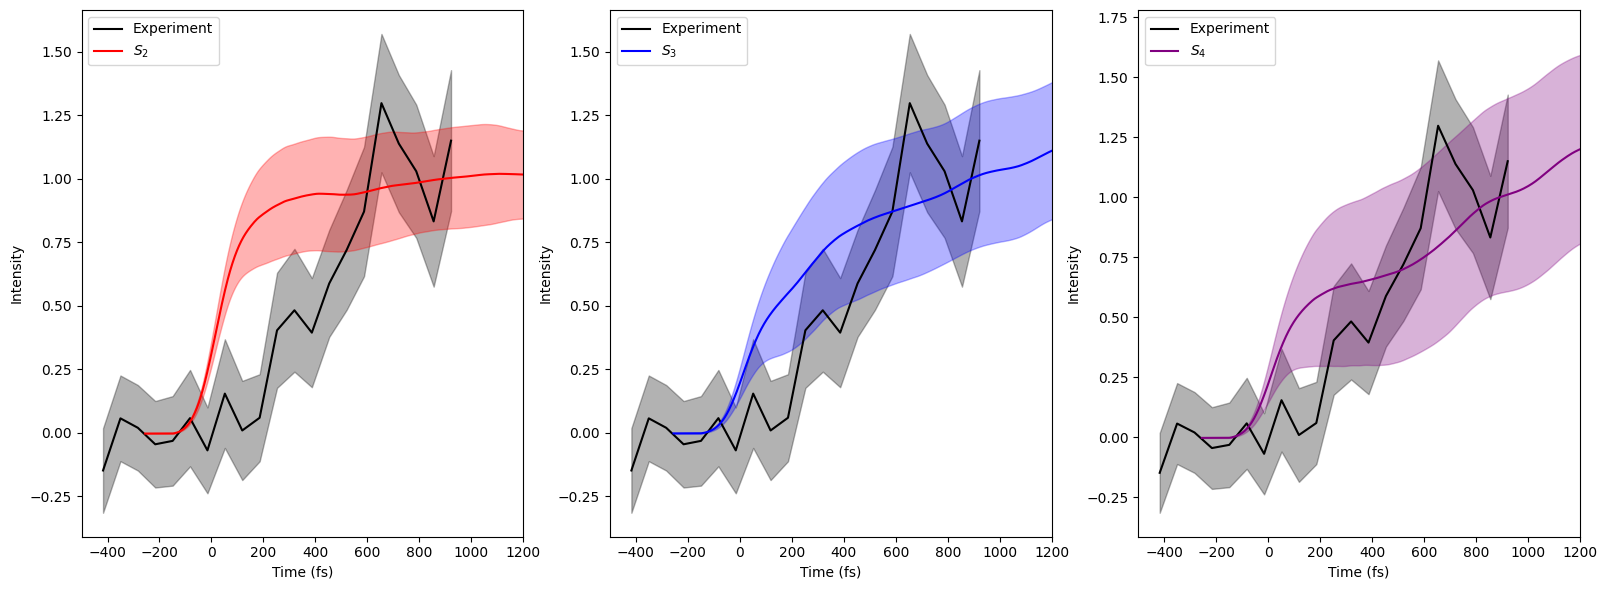

In [31]:
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err_norm, dI_I_feat1_norm+dI_I_feat1_err_norm, color='k', alpha=0.2)
#plt.errorbar(time_exp*1000, dI_I_electronic*100, yerr=dI_I_electronic_err*100, color="orange", label="Electronic Feature")
plt.plot(time_vals, NB_s2_feat1_norm,  color="blue", label="NBD Like")
#plt.plot(time_vals, NB_s2_feat_1_conv,  color="blue", label="NB Like")
plt.plot(time_vals, QC_s2_feat1_norm, color="red", label="QC like")
plt.plot(time_vals, dI_I_s2_fit_norm, color="purple", label="Weighted Average")
#plt.plot(time_vals, QC_s2_feat_1_conv, color="red", label="QC like")
#plt.plot(time_vals, (NB_s4_feat_1 + QC_s4_feat_1), label="Sum")
plt.axvline(x=NB_s2_CI, color="blue", label="NBD CI", linestyle="--")
plt.axvline(x=QC_s2_CI, color="red", label="QC CI", linestyle="--")
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.title(r'$S_{2}$')
plt.xlim(-500, 1200)
plt.legend()

plt.subplot(1,3,2)
plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err_norm, dI_I_feat1_norm+dI_I_feat1_err_norm, color='k', alpha=0.2)
#plt.errorbar(time_exp*1000, dI_I_electronic*50, yerr=dI_I_electronic_err*50, color="orange", label="Electronic Feature")
plt.plot(time_vals, NB_s3_feat1_norm,  color="blue", label="NBD Like")
#plt.plot(time_vals, NB_s2_feat_1_conv,  color="blue", label="NB Like")
plt.plot(time_vals, QC_s3_feat1_norm, color="red", label="QC like")
#plt.plot(time_vals, (NB_s4_feat_1 + QC_s4_feat_1), label="Sum")
plt.plot(time_vals, dI_I_s3_fit_norm, color="purple", label="Weighted Average")
plt.axvline(x=NB_s3_CI, color="blue", label="NBD CI", linestyle="--")
plt.axvline(x=QC_s3_CI, color="red", label="QC CI", linestyle="--")
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.title(r'$S_{3}$')
plt.xlim(-500, 1200)
plt.legend()

plt.subplot(1,3,3)
plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err_norm, dI_I_feat1_norm+dI_I_feat1_err_norm, color='k', alpha=0.2)
#plt.errorbar(time_exp*1000, dI_I_electronic*50, yerr=dI_I_electronic_err*50, color="orange", label="Electronic Feature")
plt.plot(time_vals, NB_s4_feat1_norm,  color="blue", label="NBD Like")
#plt.plot(time_vals, NB_s2_feat_1_conv,  color="blue", label="NB Like")
plt.plot(time_vals, QC_s4_feat1_norm, color="red", label="QC like")
plt.plot(time_vals, dI_I_s4_fit_norm, color="purple", label="Weighted Average")
#plt.plot(time_vals, (NB_s4_feat_1 + QC_s4_feat_1), label="Sum")
plt.axvline(x=NB_s4_CI, color="blue", label="NBD CI", linestyle="--")
plt.axvline(x=QC_s4_CI, color="red", label="QC CI", linestyle='--')
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.title(r'$S_{4}$')
plt.xlim(-500, 1200)
plt.legend()

plt.show()

plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err_norm, dI_I_feat1_norm+dI_I_feat1_err_norm, color='k', alpha=0.3)
plt.plot(time_vals, dI_I_s2_norm,  color="red", label=r'$S_{2}$')
plt.fill_between(time_vals, dI_I_s2_norm-dI_I_s2_norm_err, dI_I_s2_norm+dI_I_s2_norm_err, color='red', alpha=0.3)
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.xlim(-500, 1200)
plt.legend()

plt.subplot(1,3,2)
plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err_norm, dI_I_feat1_norm+dI_I_feat1_err_norm, color='k', alpha=0.3)
plt.plot(time_vals, dI_I_s3_norm, color="blue", label=r'$S_{3}$')
plt.fill_between(time_vals, dI_I_s3_norm-dI_I_s3_norm_err, dI_I_s3_norm+dI_I_s3_norm_err, color='blue', alpha=0.3)
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.xlim(-500, 1200)
plt.legend()

plt.subplot(1,3,3)
plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err_norm, dI_I_feat1_norm+dI_I_feat1_err_norm, color='k', alpha=0.3)
plt.plot(time_vals, dI_I_s4_norm, color='purple', label=r'$S_{4}$')
plt.fill_between(time_vals, dI_I_s4_norm-dI_I_s4_norm_err, dI_I_s4_norm+dI_I_s4_norm_err, color='purple', alpha=0.3)
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.xlim(-500, 1200)
plt.legend()

plt.tight_layout()
plt.show()

# plt.subplot(1,2,2)
# plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
# plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err_norm, dI_I_feat1_norm+dI_I_feat1_err_norm, color='k', alpha=0.2)
# plt.plot(time_vals, dI_I_s2_fit_norm,  color="blue", label=r'$S_{2}$')
# plt.plot(time_vals, dI_I_s3_fit_norm, color="red", label=r'$S_{3}$')
# plt.plot(time_vals, dI_I_s4_fit_norm, color='purple', label=r'$S_{4}$')
# plt.xlabel("Time (fs)")
# plt.ylabel("Intensity")
# plt.xlim(-500, 1200)
# plt.legend()
# plt.title("Fitting Weighted")
# plt.show()


## Old Stuff

In [36]:
print(popt_exp[2]*2*(2*np.log(2)**(1/2)))

1309.0762951595605


Optimal parameters: [ 1.00102233  0.50301527 -0.00788924  2.12220759  1.0546478   0.00397525]
Optimal parameters: [-1.13727779e-01 -2.63495893e-02  2.46414722e-01  4.61430536e+02
  1.64260696e-02 -4.58504040e+04]


C:\Users\laure\AppData\Local\Temp\ipykernel_30852\3733205032.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_exp, pcov_exp = curve_fit(combined_model, x_exp, y_exp, p0=p0)


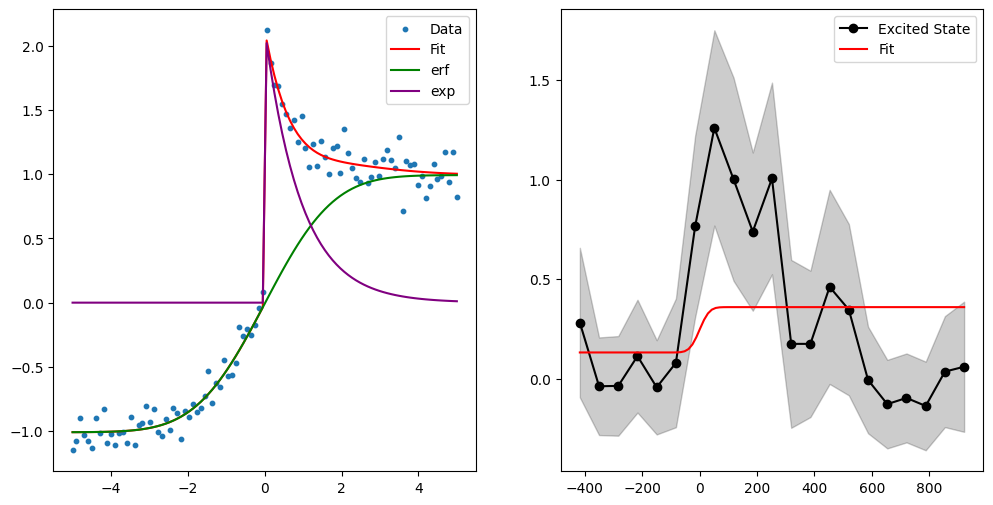

In [37]:
from scipy.optimize import curve_fit
from scipy.special import erf

# Define the Gaussian function
def gaussian(x, mu, sigma, A):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Define the Error function (erf)
def error_function(x, a, b, c):
    return a * erf(b * x) + c

# Define the exponential decay component
def exponential_decay(x, A, d, mu):
    return A * np.exp(-d * (x - mu)) * (x >= mu)  # Ensure decay starts at x >= mu

# Define the combined model: Error function + Exponential decay
def combined_model(x, a, b, c, A, d, mu):
    return error_function(x, a, b, c) + exponential_decay(x, A, d, mu)

# Generate synthetic data (you can replace this with your own data)
# Generate synthetic data
x_data = np.linspace(-5, 5, 100)
y_true = combined_model(x_data, 1.0, 0.5, 0.0, 2.0, 1.0, 0.0)  # True parameters
y_data = y_true + 0.1 * np.random.normal(size=len(x_data))  # Add noise

# Fit the data using curve_fit
p0 = [1.0, 0.5, 0.0, 2.0, 1.0, 0.0]  # Initial guesses for the parameters
popt, pcov = curve_fit(combined_model, x_data, y_data, p0=p0)

# Print the optimal parameters
print("Optimal parameters:", popt)

# Generate synthetic data (you can replace this with your own data)
#x_data = np.linspace(-5, 5, 100)
x_exp = time_new*1000
y_exp = dI_I_elec_norm

# Use curve_fit to fit the model to the data
p0 = [1.0, 0.005, 0.0, 1.0, 0.01, 200]  # Initial guesses for parameters
popt_exp, pcov_exp = curve_fit(combined_model, x_exp, y_exp, p0=p0)
x_new = np.linspace(np.min(x_exp), np.max(x_exp), 100)
# Print the optimal parameters
print("Optimal parameters:", popt_exp)

# Plot the data and the fit
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x_data, y_data, label="Data", s=10)
plt.plot(x_data, combined_model(x_data, *popt), label="Fit", color="red")
plt.plot(x_data, error_function(x_data, popt[0], popt[1], popt[2]), label="erf", color="green")
plt.plot(x_data, exponential_decay(x_data, popt[3], popt[4], popt[5]), label="exp", color="purple")
plt.legend()

plt.subplot(1,2,2)
plt.plot(x_exp, y_exp, "-o", color="k", label="Excited State")
plt.fill_between(x_exp, y_exp-dI_I_elec_err_norm, y_exp+dI_I_elec_err_norm, color='k', alpha=0.2)
plt.plot(x_new, combined_model(x_new, *popt_exp), label="Fit", color="red")
# plt.plot(x_new, error_function(x_new, popt_exp[0], popt_exp[1], popt_exp[2]), label="erf", color="green")
# plt.plot(x_new, exponential_decay(x_new, popt_exp[3], popt_exp[4], popt_exp[5]), label="exp", color="purple")
plt.legend()
plt.show()


### Gaussian convolved with erf Fit

Optimal parameters: [0.96918847 1.01234518 0.04621614 0.97095944]


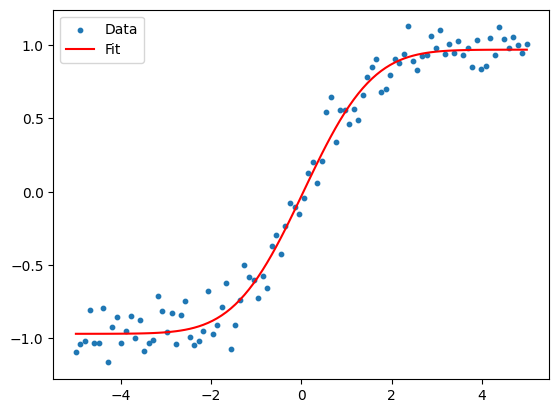

In [38]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.integrate import quad

# Define Gaussian function
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

# Define Error function (erf)
def error_function(x, a, b):
    return a * erf(b * x)

# Define the convolution of Gaussian with Error function (numerically)
def convolved_func(x, a, b, mu, sigma):
    def integrand(t, x_val):
        return error_function(t, a, b) * gaussian(x_val - t, mu, sigma)

    # Perform the convolution by integrating for each x value
    result = np.array([
        quad(integrand, -10, 10, args=(x_val,))[0]  # Finite limits to avoid errors
        for x_val in x
    ])
    return result

# Generate synthetic data
x_data = np.linspace(-5, 5, 100)
y_data = convolved_func(x_data, 1.0, 1.0, 0.0, 1.0) + 0.1 * np.random.normal(size=len(x_data))

# Define a wrapper function for curve_fit
def model(x, a, b, mu, sigma):
    return convolved_func(x, a, b, mu, sigma)

# Fit the data using curve_fit
popt, pcov = curve_fit(model, x_data, y_data, p0=[1.0, 1.0, 0.0, 1.0])

# Print the optimal parameters
print("Optimal parameters:", popt)

# Plot the data and the fit
import matplotlib.pyplot as plt

plt.scatter(x_data, y_data, label="Data", s=10)
plt.plot(x_data, model(x_data, *popt), label="Fit", color="red")
plt.legend()
plt.show()



In [39]:

# # print(dI_I_feat1.shape)
# time_vals = NB_s2_traj["0008"]["time"] + 150
# plt.figure(figsize=(16,8))
# plt.subplot(1,3,1)
# plt.plot(time_exp*1000, dI_I_mean*50, "-o", color="k", label="Experiment")
# #plt.plot(time_exp*1000, dI_I_electronic*50, "-o", color='r', label="Low s Feature")
# plt.plot(time_vals, NB_s2_mean, label="NB Like")
# plt.plot(time_vals, QC_s2_mean, label="QC like")
# #plt.plot(time_vals, (NB_s2_feat_1 + QC_s2_feat_1), label="Sum")
# plt.xlabel("Time (fs)")
# plt.ylabel("Intensity")
# plt.title("s2")
# plt.legend()

# plt.subplot(1,3,2)
# plt.plot(time_exp*1000, dI_I_mean*50, "-o", color="k", label="Experiment")
# #plt.plot(time_exp*1000, dI_I_electronic*50, "-o", color='r', label="Low s Feature")
# plt.plot(time_vals, NB_s3_mean, label="NB Like")
# plt.plot(time_vals, QC_s3_mean, label="QC like")
# #plt.plot(time_vals, (NB_s3_feat_1 + QC_s3_feat_1), label="Sum")
# plt.xlabel("Time (fs)")
# plt.ylabel("Intensity")
# plt.title("s3")
# plt.legend()

# plt.subplot(1,3,3)
# plt.plot(time_exp*1000, dI_I_mean*50, "-o", color="k", label="Experiment")
# #plt.plot(time_exp*1000, dI_I_electronic*50, "-o", color='r', label="Low s Feature")
# plt.plot(time_vals, NB_s4_mean, label="NB Like")
# plt.plot(time_vals, QC_s4_mean, label="QC like")
# #plt.plot(time_vals, (NB_s4_feat_1 + QC_s4_feat_1), label="Sum")
# plt.xlabel("Time (fs)")
# plt.ylabel("Intensity")
# plt.title("s4")
# plt.legend()

# plt.show()

## Look at only slow data

In [43]:
NB_slow_ids = []
NB_slow_CIs = []
NB_slow_dIs = []
NB_slow_groups =[]

QC_slow_ids = []
QC_slow_CIs = []
QC_slow_dIs = []
QC_slow_groups =[]

In [44]:
print(len(NB_slow_CIs))
print(len(QC_slow_CIs))

0
0


In [45]:
for key in NB_s4_traj.keys():
    if NB_s4_traj[key]["CI_time"] > 300:
        dI_I = NB_s4_traj[key]["dI_I_raw"].T
        NB_slow_ids.append(key)
        NB_slow_dIs.append(dI_I)
        NB_slow_CIs.append(NB_s4_traj[key]["CI_time"])
        NB_slow_groups.append("s4")

for key in QC_s4_traj.keys():
    if QC_s4_traj[key]["CI_time"] > 300:
        dI_I = QC_s4_traj[key]["dI_I_raw"].T
        QC_slow_ids.append(key)
        QC_slow_dIs.append(dI_I)
        QC_slow_CIs.append(QC_s4_traj[key]["CI_time"])
        QC_slow_groups.append("s4")    


In [47]:
# QC_slow_dI_mean = np.mean(np.array(QC_slow_dIs), axis=0)
# NB_slow_dI_mean = np.mean(np.array(NB_slow_dIs), axis=0)

# NB_slow_feat1 = np.mean(NB_slow_dI_mean[np.where((s_simu> 7) & (s_simu < 8))[0]], axis=0)
# QC_slow_feat1 = np.mean(QC_slow_dI_mean[np.where((s_simu >7) & (s_simu < 8))[0]], axis=0)
# print(NB_slow_feat1.shape)
# print(QC_slow_feat1.shape)

# plt.figure()
# plt.plot(time_exp*1000, dI_I_feat1*50, "-o", color='k', label="Experiment")
# plt.plot(time_vals, NB_slow_feat1, label="NB like")
# plt.plot(time_vals, QC_slow_feat1, label="QC_like")
# plt.xlabel("Time (fs)")
# plt.ylabel("Intensity")
# plt.title("s3 Slow Trajectories")
# plt.legend()
# plt.show()


## Fit all data and save fit_line to h5 file and fit details to a log file

In [21]:
# Define the error function using scipy.special.erf
# def error_function(t, a, t0, sigma, offset):
#     return a * scipy.special.erf((t-t0)/(sigma/(np.sqrt(2*np.log(2))))*np.sqrt(2)) + offset

# # Define bounds for the parameters [amplitude, t0, sigma, offset]
# bounds = ([-1, -0.5, 0, -0.1], [1, 1, 1.5, 0.1])  # lower bounds, upper bounds
# guesses = [0.01, 0.5, 0.5, 0.0]

# # Open a text file to log the results

# log_file = f'{group_name}_fit_results.txt'  # Text file to store fit results
# with open(log_file, 'a') as log:
    
#     # Write the header row only if the file is empty
#     if log.tell() == 0:
#         log.write("Run_Number\tt_0\t\tt_error\tsigma\tsigma_error\toffset\n")

#     # Open the HDF5 file for saving fit_line data
#     with h5py.File(file_name, 'a') as f:
        
#         for key in s2_trajectories.keys():
#             data = s2_trajectories[key]["dI_I_conv"].T
#             time_vals = s2_trajectories[key]["time"]
#             mean_data = np.mean(np.abs(data), axis=0)  # average the absolute value of all the data across s range
            
#             # Fit absolute value of all data
#             popt, pcov = scipy.optimize.curve_fit(error_function, time_vals, mean_data, p0=guesses, bounds=bounds)
#             A, t0, sigma, offset = popt
#             t0_error = np.sqrt(pcov[1, 1])
#             sigma_error = np.sqrt(pcov[2, 2])
            
#             # Write the fitting results to the text file in tab-separated format
#             log.write(f"{key}\t{t0:.4f}\t{t0_error:.3f}\t{sigma:.4f}\t{sigma_error:.3f}\t{offset:.4f}\n")
#             print(f"{key}\t{t0:.4f}\t{t0_error:.3f}\t{sigma:.4f}\t{sigma_error:.3f}\t{offset:.4f}\n")
#             print(f"Run {key} results written to file.")
            
#             # Generate the fit line
#             fit_line = error_function(time_vals, A, t0, sigma, offset)
            
#             # Navigate to the group in the HDF5 file (create if not exists)
#             if group_name not in f:
#                 group = f.create_group(group_name)
#             else:
#                 group = f[group_name]
            
#             # Check if the dataset already exists and overwrite it
#             dataset_name = f"fit_line_run_{key}"
#             if dataset_name in group:
#                 print(f"Overwriting dataset '{dataset_name}'")
#                 del group[dataset_name]
            
#             # Create the dataset for the fit_line
#             group.create_dataset(dataset_name, data=fit_line)
#             print(f"Fit line for run {key} saved successfully.")



0014	-0.5000	1.979	1.5000	6.589	0.1000

Run 0014 results written to file.
Fit line for run 0014 saved successfully.
0050	-0.5000	1.833	1.5000	6.102	0.1000

Run 0050 results written to file.
Fit line for run 0050 saved successfully.
0054	-0.1445	0.000	0.0103	0.000	0.1000

Run 0054 results written to file.
Fit line for run 0054 saved successfully.
0066	-0.5000	1.330	1.5000	4.427	0.1000

Run 0066 results written to file.
Fit line for run 0066 saved successfully.
0091	-0.5000	3.543	1.5000	11.799	0.1000

Run 0091 results written to file.
Fit line for run 0091 saved successfully.
0111	-0.5000	1.526	1.5000	5.080	0.1000

Run 0111 results written to file.
Fit line for run 0111 saved successfully.
0113	-0.5000	1.958	1.5000	6.519	0.1000

Run 0113 results written to file.
Fit line for run 0113 saved successfully.
0152	-0.5000	1.895	1.5000	6.309	0.1000

Run 0152 results written to file.
Fit line for run 0152 saved successfully.
0229	-0.5000	2.528	1.5000	8.417	0.1000

Run 0229 results written to fil

## Get Product Ratios

In [35]:
import numpy as np
from pyswarm import pso  # Particle Swarm Optimization
import random

def three_param_fit(data, err, dI_I_fit1, dI_I_fit2, dI_I_fit3, nSwarm=2000, s_start=50, s_end=370):
    random.seed()  # Equivalent to rng('shuffle')

    # Lower and upper bounds
    lb = [0.0001, 0, 0, -200]
    ub = [100, 100, 200, 500]

    s = np.arange(0, len(data)) * 0.025  # creating s range

    # Particle Swarm Optimization
    def findCorrPar(c):
        total_perc = c[0] + c[1] + c[2]
        dI_I_end = (1 / total_perc) * (c[0] * dI_I_fit1 + c[1] * dI_I_fit2 + c[2] * dI_I_fit3)

        # Chi-squared like calculation (objective function)
        obj = (1 / (s_end - s_start) - len(lb)) * np.nansum(
            ((data[s_start:s_end] - (1 / c[3]) * dI_I_end[s_start:s_end]) / err[s_start:s_end]) ** 2
        )
        
        # Penalty to ensure that total percentage sums to 100
        penalty = 1e6 * (total_perc - 100) ** 2
        
        return obj + penalty  # Add penalty to objective function

    # Perform the PSO optimization
    coeffs, fopt = pso(findCorrPar, lb, ub, swarmsize=nSwarm, maxiter=nSwarm * 2, 
                       minstep=1e-4, debug=True)

    # Extract coefficients
    c = coeffs
    total_final = c[0] + c[1] + c[2]
    
    # Calculate dI_I_end and percentages
    dI_I_end = (1 / total_final) * (c[0] * dI_I_fit1 + c[1] * dI_I_fit2 + c[2] * dI_I_fit3)
    perc1 = (c[0] / total_final) * 100
    perc2 = (c[1] / total_final) * 100
    perc3 = (c[2] / total_final) * 100

    # Chi-squared calculation
    chi = (1 / (s_end - s_start) - len(lb)) * np.nansum(
        ((data[s_start:s_end] - (1 / c[3]) * dI_I_end[s_start:s_end]) / err[s_start:s_end]) ** 2
    )
    
    print(chi)

    return coeffs, perc1, perc2, perc3, dI_I_end, chi




In [36]:
late_dI = np.nanmean(dI_I_smooth[:, np.where((time_exp<0.7)&(time_exp<1))[0]], axis=1)
late_dI_std = np.nanstd(dI_I_smooth[:][:-4], axis=1)

coeffs, perc_NB, perc_QC, perc_frags, dI_I_fit, chi = three_param_fit(late_dI, late_dI_std, (NBD_simu/100), (QC_simu/100), (frag_simu/100))

C:\Users\laure\AppData\Local\Temp\ipykernel_4916\3521490077.py:1: RuntimeWarning: Mean of empty slice
  late_dI = np.nanmean(dI_I_smooth[:, np.where((time_exp<0.7)&(time_exp<1))[0]], axis=1)
c:\Users\laure\OneDrive - University of Nebraska-Lincoln\Desktop\gued\.conda\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


No constraints given.
New best for swarm at iteration 1: [100.           0.           0.          34.63863431] -484.75844445473285
New best for swarm at iteration 1: [ 100.    0.    0. -200.] -504.76619291788523
New best for swarm at iteration 1: [100.           0.           0.         -29.29678644] -527.635919718125
Best after iteration 1: [100.           0.           0.         -29.29678644] -527.635919718125
New best for swarm at iteration 2: [100.           0.           0.          -4.35345746] -816.6608432149404
Best after iteration 2: [100.           0.           0.          -4.35345746] -816.6608432149404
New best for swarm at iteration 3: [100.           0.           0.          -3.38511609] -966.7066514790308
New best for swarm at iteration 3: [9.64943455e+01 4.32981091e+01 0.00000000e+00 8.55886362e-05] -200196614308.28342
Best after iteration 3: [9.64943455e+01 4.32981091e+01 0.00000000e+00 8.55886362e-05] -200196614308.28342
Best after iteration 4: [9.64943455e+01 4.3298109

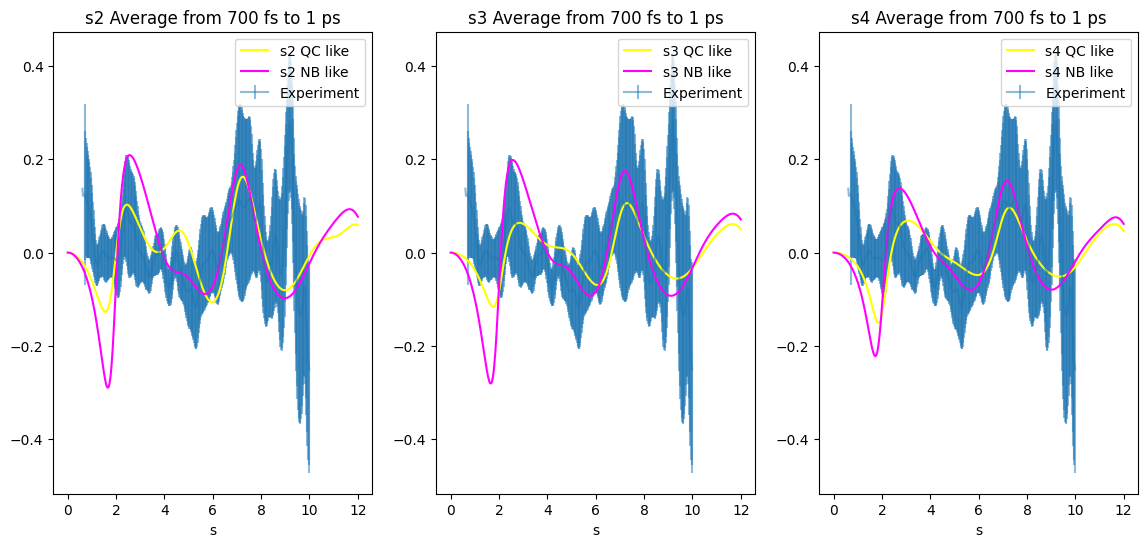

In [37]:
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.errorbar(s_simu[4:], late_dI[4:]*100, yerr=late_dI_std*100, alpha=0.5, label="Experiment")
plt.plot(QC_s2_traj["0014"]["s"], QC_s2_late, color="yellow", label="s2 QC like")
plt.plot(NB_s2_traj["0020"]["s"], NB_s2_late, color="magenta", label="s2 NB like")
plt.xlabel("s")
plt.title("s2 Average from 700 fs to 1 ps")
plt.legend()

plt.subplot(1,3,2)
plt.errorbar(s_simu[4:], late_dI[4:]*100, yerr=late_dI_std*100, alpha=0.5, label="Experiment")
plt.plot(QC_s2_traj["0014"]["s"], QC_s3_late, color="yellow", label="s3 QC like")
plt.plot(NB_s2_traj["0020"]["s"], NB_s3_late, color="magenta", label="s3 NB like")
plt.xlabel("s")
plt.title("s3 Average from 700 fs to 1 ps")
plt.legend()

plt.subplot(1,3,3)
plt.errorbar(s_simu[4:], late_dI[4:]*100, yerr=late_dI_std*100, alpha=0.5, label="Experiment")
plt.plot(QC_s2_traj["0014"]["s"], QC_s4_late, color="yellow", label="s4 QC like")
plt.plot(NB_s2_traj["0020"]["s"], NB_s4_late, color="magenta", label="s4 NB like")
plt.xlabel("s")
plt.title("s4 Average from 700 fs to 1 ps")
plt.legend()

plt.show()

In [48]:

# plt.figure()
# plt.plot(s_simu[4:], late_dI)
# plt.plot(s_simu, dI_I_fit)
# plt.show()

In [150]:
late_data = np.nanmean(dI_I_boot[:, 0:4, :], axis=1)
# print(late_data.shape)
print(time_exp)
# np.where((time_exp>0.9) & (time_exp < 1.1))[0]
print(late_data.shape)
late_dict = {"late_dIs": late_data}
s_vals = {"s_values": s_simu}

savemat("C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\late_dI_I.mat", late_dict)
savemat("C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\s_values.mat", s_vals)

[ 1.00429653  0.9373434   0.87039033  0.80343727  0.73648413  0.66953107
  0.60257793  0.5356248   0.46867173  0.4017186   0.33476553  0.26781247
  0.20085933  0.13390627  0.06695313 -0.         -0.06695307 -0.1339062
 -0.20085927 -0.26781233 -0.33476547 -0.40171853 -0.46867167 -0.53562473
 -0.60257787]
(412, 100)


### Fitting Average of Bootstrap

In [62]:
# zero-fitting method for background subtraction
from scipy.signal import find_peaks

def get_upper_limit(peak_index, s, theory_data, lower_num_limit):
    temp_arr = []
    for k in np.arange(peak_index+1, len(s), 1):
        temp_mean_limit = np.mean(theory_data[peak_index-lower_num_limit:k])
        temp_arr.append(temp_mean_limit)
    
    temp_arr = np.array(temp_arr)
    temp_peaks, _ = find_peaks((temp_arr**2)*-1-np.amin(temp_arr**2*-1))
    if len(temp_peaks)==0:
        upper_num_limit = len(s)
    else:
        upper_num_limit = np.arange(peak_index+1, len(s), 1)[temp_peaks[0]]
    return upper_num_limit

def zeros_position_finder_update(s, exp_delii, theory_delii, num_limit=20, poly_order=3):
    temp_dii = theory_delii**2*-1-np.amin(theory_delii**2*-1)
    peaks, _ = find_peaks(temp_dii)
    print(peaks)
    
    zero_cross = np.zeros_like(peaks, dtype=float)
    for j in range(len(peaks)):
        if num_limit==0:
            zero_cross[j] = exp_delii[peaks[j]]
        else:
            if peaks[j] == 0 or peaks[j] == len(temp_dii)-1:
                zero_cross[j] = exp_delii[peaks[j]]
            else:
                if peaks[j] < num_limit and peaks[j] > 0:
                    temp_num_limit = peaks[j]
                elif peaks[j] > len(temp_dii)-num_limit and peaks[j] < len(temp_dii)-1:
                    temp_num_limit = int(len(temp_dii) - 1 - peaks[j])
                else:
                    temp_num_limit = num_limit

                upper_num_limit = get_upper_limit(peak_index=peaks[j], s=s, theory_data=theory_delii, lower_num_limit=temp_num_limit)
                zero_cross[j] = np.mean(exp_delii[peaks[j]-temp_num_limit:upper_num_limit])
                
                #V[j] = np.mean(self.smoothed_exp_raw_data[peaks[j]-temp_num_limit:peaks[j]+temp_num_limit]) # Old way
    if len(s[peaks])==0:
        bg_free_exp_delii = np.copy(exp_delii)
    else:
        poly_smoothed_dii, residuals, _, _, _ = np.polyfit(s[peaks], zero_cross, deg=poly_order, full=True)
        basefit_dii = np.polyval(poly_smoothed_dii, s)
        bg_free_exp_delii = exp_delii - basefit_dii
    return bg_free_exp_delii

def zero_correction(x_data, y_data, theory_data):
    zero_crossings = np.where(np.diff(np.sign(theory_data)))[0]
    
    if zero_crossings.size == 0:  # No zero crossings found
        print("Warning: No zero crossings found. Returning uncorrected data.")
        return np.zeros_like(x_data), y_data  # No baseline correction
    # for zero in zero_crossings:
    #     print(y_data[zero+10]+y_data[zero-10])
    # Proceed with zero-crossing-based correction
    #print(f"Found zeros at {x_data[zero_crossings]}")
    coeffs = np.polyfit(x_data[zero_crossings], y_data[zero_crossings], 3)
    baseline = np.polyval(coeffs, x_data)
    fixed_data = y_data - baseline
    return baseline, fixed_data


In [63]:
s_min = 0.6
s_max = 9
s_idx = np.where((s_simu > s_min) & (s_simu < s_max))[0]

def model(x, a, b, c):
    fit_result = a*(QC_late_resampled[s_idx]) + b*(NB_late_resampled[s_idx]) + c*(frag_simu[s_idx])

    return fit_result

def cost_func(params):
    return np.sum((ave_data-model(x_data, *params))**2)

def zero_fit_cost_func(params, x_data, y_data, std_data):
    theory_line = model(x_data, *params)
    _, corrected_data = zero_correction(x_data, y_data, theory_line)
    residuals = corrected_data - model(x_data, *params)
    weighted_residuals = residuals / std_data  # Divide residuals by uncertainties
    return np.sum(weighted_residuals**2)

def weighted_cost_func(params, x_data, y_data, std_data):
    residuals = y_data - model(x_data, *params)
    weighted_residuals = residuals / std_data  # Divide residuals by uncertainties
    return np.sum(weighted_residuals**2)

x_data = s_simu[s_idx]
print(dI_I_boot.shape)

late_data = np.array(np.nanmean(dI_I_boot[:, 0:6, :], axis=1))
late_data_std = np.nanstd(dI_I_boot[:, 0, :], axis=1)
late_data_std = late_data_std[s_idx]
print(f"shape of std of late data matrix {late_data_std.shape}")
y_data = np.nanmean(late_data, axis=1)[s_idx]
ave_data = np.nanmean(late_data, axis=1)[s_idx]
print(ave_data.shape)
print(y_data.shape)
print(x_data.shape)

# Gradient Based Curve Fit
bounds = ([0, 0, 0], [0.1, 0.1, 0.1])
#Fit the data using curve_fit
popt, pcov = curve_fit(model, x_data, ave_data, sigma=late_data_std, bounds=bounds)

print(f"curve fit found values of a, b, c = {popt}")

perc_QC = (popt[0]/(popt[0]+popt[1]+popt[2]))*100
perc_NB = (popt[1]/(popt[0]+popt[1]+popt[2]))*100
perc_frags = (popt[2]/(popt[0]+popt[1]+popt[2]))*100

perc_fit_line = model(x_data, *popt)


rmse = np.sqrt(np.nanmean(ave_data-perc_fit_line)**2)
print("Results from Basic Curve Fit \n")
print(f"RMSE = {rmse}")
# Print the optimal parameters
print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags} \n total percent = {perc_QC+perc_NB+perc_frags} \n")

# Simulated Annealing 

print("Results from Dual Annealing \n")
bounds = [(0,0.05), (0,0.05), (0,0.05)]
result = dual_annealing(weighted_cost_func, bounds=bounds, args=(x_data, ave_data, late_data_std), no_local_search=True)
sa_params = result.x
print(f"dual annealing found results of a, b, c = {sa_params}")
print(result)

perc_QC = (sa_params[0]/(sa_params[0]+sa_params[1]+sa_params[2]))*100
perc_NB = (sa_params[1]/(sa_params[0]+sa_params[1]+sa_params[2]))*100
perc_frags = (sa_params[2]/(sa_params[0]+sa_params[1]+sa_params[2]))*100

perc_fit_line = model(x_data, *sa_params)

_, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)

rmse = np.sqrt(np.nanmean(corrected_data-perc_fit_line)**2)

print(f"RMSE = {rmse}")
# Print the optimal parameters
print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags} \n total percent = {perc_QC+perc_NB+perc_frags} \n")

# PSO
print("Results from Differential Evolution \n")
bounds = [(0,0.05), (0,0.05), (0,0.05)]
result = differential_evolution(weighted_cost_func, bounds=bounds, args=(x_data, ave_data, late_data_std))
sa_params = result.x
print(f"differential evolution found results of a, b, c = {sa_params}")
print(result)

perc_QC = (sa_params[0]/(sa_params[0]+sa_params[1]+sa_params[2]))*100
perc_NB = (sa_params[1]/(sa_params[0]+sa_params[1]+sa_params[2]))*100
perc_frags = (sa_params[2]/(sa_params[0]+sa_params[1]+sa_params[2]))*100

perc_fit_line = model(x_data, *sa_params)

_, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)

rmse = np.sqrt(np.nanmean(corrected_data-perc_fit_line)**2)

print(f"RMSE = {rmse}")
# Print the optimal parameters
print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags} \n total percent = {perc_QC+perc_NB+perc_frags}")

(412, 25, 100)
shape of std of late data matrix (346,)
(346,)
(346,)
(346,)
curve fit found values of a, b, c = [0.00628711 0.00203534 0.00248013]
Results from Basic Curve Fit 

RMSE = 1.3350388663790922e-05
 percent QC = 58.20009214490065 
 percent NBD = 18.841214153306872 
 percent fragments = 22.958693701792477 
 total percent = 100.0 

Results from Dual Annealing 

dual annealing found results of a, b, c = [0.0077677  0.00136517 0.00252431]
 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 405.0698348751859
       x: [ 7.768e-03  1.365e-03  2.524e-03]
     nit: 1000
    nfev: 6001
    njev: 0
    nhev: 0
RMSE = 0.00025104784441339707
 percent QC = 66.63441795474986 
 percent NBD = 11.711012331709588 
 percent fragments = 21.654569713540546 
 total percent = 100.0 

Results from Differential Evolution 

differential evolution found results of a, b, c = [0.00628716 0.00203531 0.00248013]
             message: Optimization terminated successfully.


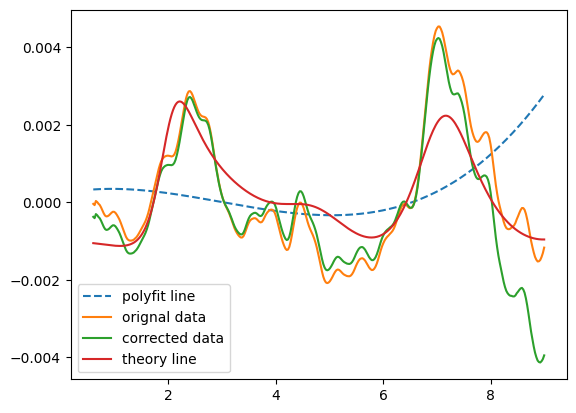

In [64]:
baseline, new_data = zero_correction(x_data, ave_data, perc_fit_line)

plt.figure()
plt.plot(x_data, baseline, "--", label="polyfit line")
plt.plot(x_data, ave_data, label="orignal data")
plt.plot(x_data, new_data, label="corrected data")
plt.plot(x_data, perc_fit_line, label="theory line")
plt.legend()
plt.show()

### Fitting All Bootstrap Data

In [65]:
all_perc_QC = []
all_perc_NB = []
all_perc_frags = []
all_fits = []
all_rmse = []
all_chi_sq = []

anneal_perc_QC = []
anneal_perc_NB = []
anneal_perc_frag = []
anneal_fits = []
anneal_rmse = []
anneal_chi_sq = []
anneal_corrected = []
anneal_fail = []

pso_perc_QC = []
pso_perc_NB = []
pso_perc_frag = []
pso_fits = []
pso_rmse = []
pso_chi_sq = []
pso_corrected = []
pso_fail = []

for i in range(0, 100):
    y_data = late_data[s_idx, i]

    bounds = ([0, 0, 0], [0.01, 0.01, 0.01])
    #Fit the data using curve_fit
    print("Results from Basic Curve Fit \n")
    popt, pcov = curve_fit(model, x_data, y_data, sigma=late_data_std, bounds=bounds)

    perc_QC = (popt[0]/(popt[0]+popt[1]+popt[2]))*100
    perc_NB = (popt[1]/(popt[0]+popt[1]+popt[2]))*100
    perc_frags = (popt[2]/(popt[0]+popt[1]+popt[2]))*100

    perc_fit_line = model(x_data, *popt)

    all_perc_QC.append(perc_QC)
    all_perc_NB.append(perc_NB)
    all_perc_frags.append(perc_frags)
    all_fits.append(perc_fit_line)

    rmse = np.sqrt(np.nanmean(y_data-perc_fit_line)**2)
    all_rmse.append(rmse)
    chi_sq = np.sum(((y_data-perc_fit_line)**2)/(late_data_std**2))
    all_chi_sq.append(chi_sq)

    print(f"RMSE for run {i} = {rmse}, chi^2 = {chi_sq}")
    # Print the optimal parameters
    # print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags} \n total percent = {perc_QC+perc_NB+perc_frags}")

    print("Results from Dual Annealing \n")
    bounds = [(0,0.05), (0,0.05), (0,0.05)]
    result = dual_annealing(zero_fit_cost_func, bounds=bounds, args=(x_data, y_data, late_data_std), no_local_search=True)
    sa_params = result.x
    print(result.message)
    if result.nit == 1000:
        anneal_fail.append(1)
    else:
        anneal_fail.append(0)

    perc_QC = (sa_params[0]/(sa_params[0]+sa_params[1]+sa_params[2]))*100
    perc_NB = (sa_params[1]/(sa_params[0]+sa_params[1]+sa_params[2]))*100
    perc_frags = (sa_params[2]/(sa_params[0]+sa_params[1]+sa_params[2]))*100

    perc_fit_line = model(x_data, *sa_params)

    anneal_perc_QC.append(perc_QC)
    anneal_perc_NB.append(perc_NB)
    anneal_perc_frag.append(perc_frags)
    anneal_fits.append(perc_fit_line)

    _, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)
    anneal_corrected.append(corrected_data)

    rmse = np.sqrt(np.nanmean(corrected_data-perc_fit_line)**2)
    anneal_rmse.append(rmse)
    chi_sq = np.sum(((corrected_data-perc_fit_line)**2)/(late_data_std**2))
    anneal_chi_sq.append(chi_sq)

    # rmse = np.sqrt(np.nanmean(y_data-perc_fit_line)**2)
    # anneal_rmse.append(rmse)
    # chi_sq = np.sum(((y_data-perc_fit_line)**2)/(late_data_std**2))
    # anneal_chi_sq.append(chi_sq)

    print(f"RMSE for run {i} = {rmse}, chi^2 = {chi_sq}")
    # Print the optimal parameters
    # print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags} \n total percent = {perc_QC+perc_NB+perc_frags}")

    print("Results from Differential Evolution \n")
    bounds = [(0,0.05), (0,0.05), (0,0.05)]
    result = differential_evolution(zero_fit_cost_func, bounds=bounds, args=(x_data, y_data, late_data_std), maxiter=1000)
    sa_params = result.x
    print(result.message)
    if result.nit == 1000:
        anneal_fail.append(1)
    else:
        anneal_fail.append(0)

    perc_QC = (sa_params[0]/(sa_params[0]+sa_params[1]+sa_params[2]))*100
    perc_NB = (sa_params[1]/(sa_params[0]+sa_params[1]+sa_params[2]))*100
    perc_frags = (sa_params[2]/(sa_params[0]+sa_params[1]+sa_params[2]))*100


    perc_fit_line = model(x_data, *sa_params)

    pso_perc_QC.append(perc_QC)
    pso_perc_NB.append(perc_NB)
    pso_perc_frag.append(perc_frags)
    pso_fits.append(perc_fit_line)

    _, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)
    pso_corrected.append(corrected_data)

    chi_sq = np.sum(((corrected_data-perc_fit_line)**2)/(late_data_std**2))
    pso_chi_sq.append(chi_sq)
    rmse = np.sqrt(np.nanmean(corrected_data-perc_fit_line)**2)
    pso_rmse.append(rmse)

    # chi_sq = np.sum(((y_data-perc_fit_line)**2)/(late_data_std**2))
    # pso_chi_sq.append(chi_sq)
    # rmse = np.sqrt(np.nanmean(y_data-perc_fit_line)**2)
    # pso_rmse.append(rmse)

    print(f"RMSE for data {i} = {rmse}, chi^2 = {chi_sq}")
    # Print the optimal parameters
    # print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags} \n total percent = {perc_QC+perc_NB+perc_frags}")

    

all_perc_QC = np.array(all_perc_QC)
all_perc_NB = np.array(all_perc_NB)
all_perc_frags = np.array(all_perc_frags)
all_fits = np.array(all_fits)
all_rmse = np.array(all_rmse)
all_chi_sq = np.array(all_chi_sq)
# print(f" shape of % QC = {all_perc_QC.shape} \n shape of % NB = {all_perc_NB.shape} \n shape of all % frags = {all_perc_frags.shape} \
#       \n fits shape = {all_fits.shape}")

anneal_perc_QC = np.array(anneal_perc_QC)
anneal_perc_NB = np.array(anneal_perc_NB)
anneal_perc_frag = np.array(anneal_perc_frag)
anneal_fits = np.array(anneal_fits)
anneal_rmse = np.array(anneal_rmse)
anneal_chi_sq = np.array(anneal_chi_sq)
anneal_corrected = np.array(anneal_corrected)

pso_perc_QC = np.array(pso_perc_QC)
pso_perc_NB = np.array(pso_perc_NB)
pso_perc_frag = np.array(pso_perc_frag)
pso_fits = np.array(pso_fits)
pso_rmse = np.array(pso_rmse)
pso_chi_sq = np.array(pso_chi_sq)
pso_corrected = np.array(pso_corrected)

ave_exp = np.nanmean(late_data, axis=1)[s_idx]
print(ave_exp.shape)

ave_fits = np.nanmean(all_fits, axis=0)
ave_fits_std = np.nanstd(all_fits, axis=0)

ave_anneal = np.nanmean(anneal_fits, axis=0)
ave_anneal_corrected = np.nanmean(anneal_corrected, axis=0)
std_anneal_corrected = np.nanstd(anneal_corrected, axis=0)
ave_anneal_std = np.nanstd(anneal_fits, axis=0)

ave_pso = np.nanmean(pso_fits, axis=0)
ave_pso_corrected = np.nanmean(pso_corrected, axis=0)
std_pso_corrected = np.nanstd(pso_corrected, axis=0)
ave_pso_std = np.nanstd(pso_fits, axis=0)



Results from Basic Curve Fit 

RMSE for run 0 = 0.00010292536282295755, chi^2 = 572.8515073707134
Results from Dual Annealing 

['Maximum number of iteration reached']
RMSE for run 0 = 0.0002494294903585855, chi^2 = 612.8290391947683
Results from Differential Evolution 

Optimization terminated successfully.
RMSE for data 0 = 0.0002507249482591031, chi^2 = 597.1310453241977
Results from Basic Curve Fit 

RMSE for run 1 = 2.773020000912296e-05, chi^2 = 561.2236336065205
Results from Dual Annealing 

['Maximum number of iteration reached']
RMSE for run 1 = 0.00037552953936077386, chi^2 = 519.2879510127904
Results from Differential Evolution 

Optimization terminated successfully.
RMSE for data 1 = 0.00031492054466247636, chi^2 = 295.71344771192935
Results from Basic Curve Fit 

RMSE for run 2 = 2.3274890565881166e-05, chi^2 = 630.7976141162952
Results from Dual Annealing 

['Maximum number of iteration reached']
RMSE for run 2 = 0.0002528009134783683, chi^2 = 332.31652166550634
Results f

In [66]:
pso_chi_sq = pso_chi_sq/(len(ave_data)-3)
anneal_chi_sq = anneal_chi_sq/(len(ave_data)-3)
all_chi_sq = all_chi_sq/(len(ave_data)-3)


In [67]:
print(np.std(pso_chi_sq))
good_idx = np.where((pso_chi_sq > (np.mean(pso_chi_sq - np.std(pso_chi_sq)))) & (pso_chi_sq < (np.mean(pso_chi_sq + np.std(pso_chi_sq)))))[0]
print(len(good_idx), len(pso_chi_sq))

1.3339196116931662
95 100


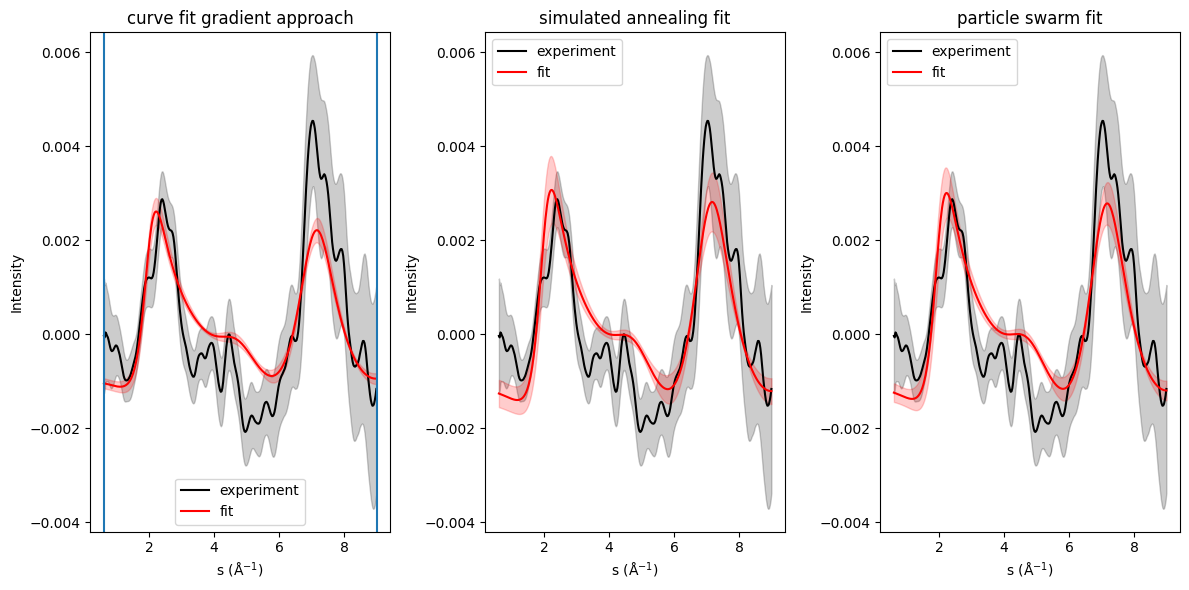

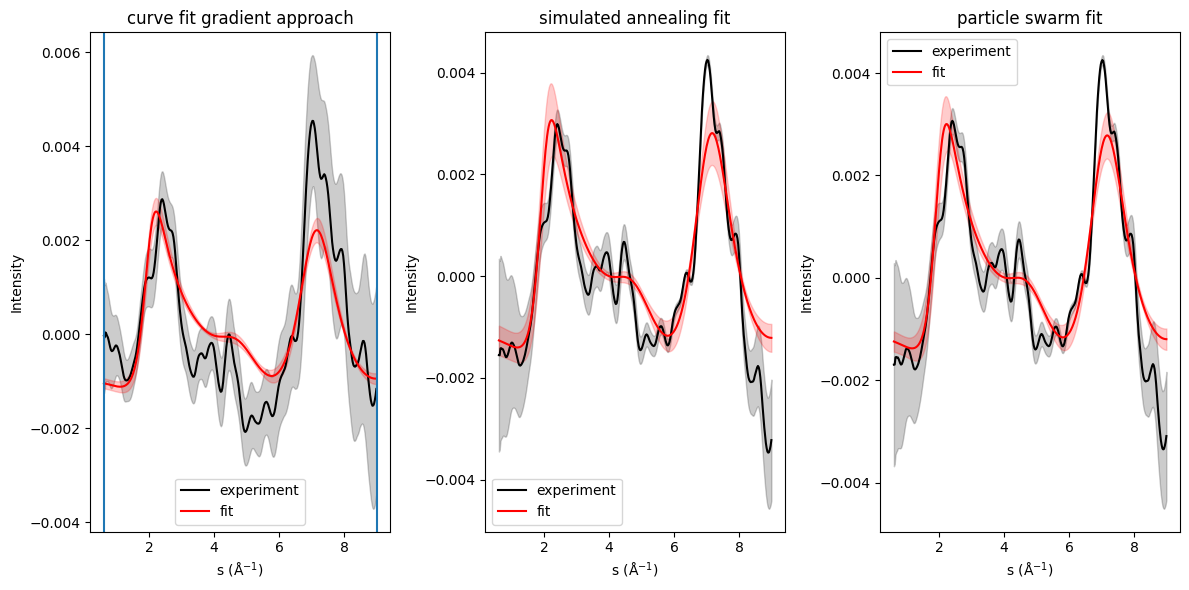

CURVE FIT
 percent QC = 50.37371800020189 +/- 26.797531516403158 
 percent NBD = 25.27014869452179 +/- 22.894505585305684 
 percent fragments = 24.35613330527632       +/- 5.236779113639592 
 total percent = 100.0
RMSE = 1.2174420821423953e-05
ANNEALING
 percent QC = 59.553768127496966 +/- 21.37036399054553 
 percent NBD = 18.363376489530104 +/- 16.78970483876596 
 percent fragments = 22.08285538297292        +/- 8.346073372501158 
 total percent = 100.0
RMSE = 5.011876369623349e-05
PARTICLE SWARM
 percent QC = 62.13319035571045 +/- 22.128094780955276 
 percent NBD = 15.953227231875683 +/- 16.662719484672234 
 percent fragments = 21.91358241241388        +/- 8.200262473579484 
 total percent = 100.0
RMSE = 4.663603324157334e-05


In [68]:
plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.plot(x_data, ave_exp, color='k', label="experiment")
plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_fits, color='r', label="fit")
plt.fill_between(x_data, ave_fits-ave_fits_std, ave_fits+ave_fits_std, color='r', alpha=0.2)
plt.axvline(s_min)
plt.axvline(s_max)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("curve fit gradient approach")
plt.legend()

plt.subplot(1,3,2)
plt.plot(x_data, ave_exp, color='k', label="experiment")
plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_anneal, color='r', label="fit")
plt.fill_between(x_data, ave_anneal-ave_anneal_std, ave_anneal+ave_anneal_std, color='r', alpha=0.2)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("simulated annealing fit")
plt.legend()

plt.subplot(1,3,3)
plt.plot(x_data, ave_exp, color='k', label="experiment")
plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_pso, color='r', label="fit")
plt.fill_between(x_data, ave_pso-ave_pso_std, ave_pso+ave_pso_std, color='r', alpha=0.2)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("particle swarm fit")
plt.legend()
plt.tight_layout()

plt.show()

plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.plot(x_data, ave_exp, color='k', label="experiment")
plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_fits, color='r', label="fit")
plt.fill_between(x_data, ave_fits-ave_fits_std, ave_fits+ave_fits_std, color='r', alpha=0.2)
plt.axvline(s_min)
plt.axvline(s_max)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("curve fit gradient approach")
plt.legend()

plt.subplot(1,3,2)
plt.plot(x_data, ave_anneal_corrected, color='k', label="experiment")
plt.fill_between(x_data, ave_anneal_corrected-std_anneal_corrected, ave_anneal_corrected+std_anneal_corrected, color='k', alpha=0.2)
plt.plot(x_data, ave_anneal, color='r', label="fit")
plt.fill_between(x_data, ave_anneal-ave_anneal_std, ave_anneal+ave_anneal_std, color='r', alpha=0.2)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("simulated annealing fit")
plt.legend()

plt.subplot(1,3,3)
plt.plot(x_data, ave_pso_corrected, color='k', label="experiment")
plt.fill_between(x_data, ave_pso_corrected-std_pso_corrected, ave_pso_corrected+std_pso_corrected, color='k', alpha=0.2)
plt.plot(x_data, ave_pso, color='r', label="fit")
plt.fill_between(x_data, ave_pso-ave_pso_std, ave_pso+ave_pso_std, color='r', alpha=0.2)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("particle swarm fit")
plt.legend()
plt.tight_layout()

plt.show()

ave_perc_QC = np.mean(all_perc_QC)
std_perc_QC = np.std(all_perc_QC)
ave_perc_NB = np.mean(all_perc_NB)
std_perc_NB = np.std(all_perc_NB)
ave_perc_frags = np.mean(all_perc_frags)
std_perc_frags = np.std(all_perc_frags)

ave_anneal_QC = np.mean(anneal_perc_QC)
std_anneal_QC = np.std(anneal_perc_QC)
ave_anneal_NB = np.mean(anneal_perc_NB)
std_anneal_NB = np.std(anneal_perc_NB)
ave_anneal_frags = np.mean(anneal_perc_frag)
std_anneal_frags = np.std(anneal_perc_frag)

ave_pso_QC = np.mean(pso_perc_QC[good_idx])
std_pso_QC = np.std(pso_perc_QC[good_idx])
ave_pso_NB = np.mean(pso_perc_NB[good_idx])
std_pso_NB = np.std(pso_perc_NB[good_idx])
ave_pso_frags = np.mean(pso_perc_frag[good_idx])
std_pso_frags = np.std(pso_perc_frag[good_idx])

ave_pso_QC = np.mean(pso_perc_QC)
std_pso_QC = np.std(pso_perc_QC)
ave_pso_NB = np.mean(pso_perc_NB)
std_pso_NB = np.std(pso_perc_NB)
ave_pso_frags = np.mean(pso_perc_frag)
std_pso_frags = np.std(pso_perc_frag)

print("CURVE FIT")
print(f" percent QC = {ave_perc_QC} +/- {std_perc_QC} \n percent NBD = {ave_perc_NB} +/- {std_perc_NB} \n percent fragments = {ave_perc_frags} \
      +/- {std_perc_frags} \n total percent = {ave_perc_QC+ave_perc_NB+ave_perc_frags}")
rmse = np.sqrt(np.nanmean(ave_exp-ave_fits)**2)
print(f"RMSE = {rmse}")
print("ANNEALING")
print(f" percent QC = {ave_anneal_QC} +/- {std_anneal_QC} \n percent NBD = {ave_anneal_NB} +/- {std_anneal_NB} \n percent fragments = {ave_anneal_frags} \
       +/- {std_anneal_frags} \n total percent = {ave_anneal_QC+ave_anneal_NB+ave_anneal_frags}")
rmse = np.sqrt(np.nanmean(ave_exp-ave_anneal)**2)
print(f"RMSE = {rmse}")
print("PARTICLE SWARM")
print(f" percent QC = {ave_pso_QC} +/- {std_pso_QC} \n percent NBD = {ave_pso_NB} +/- {std_pso_NB} \n percent fragments = {ave_pso_frags} \
       +/- {std_pso_frags} \n total percent = {ave_pso_QC+ave_pso_NB+ave_pso_frags}")
rmse = np.sqrt(np.nanmean(ave_exp-ave_pso)**2)
print(f"RMSE = {rmse}")

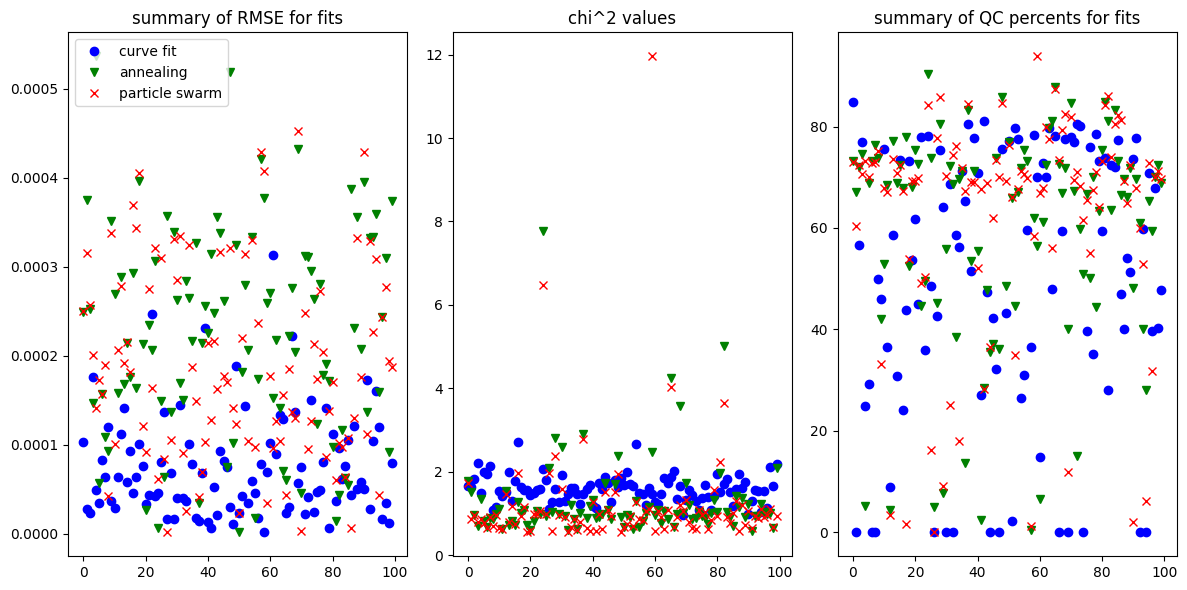

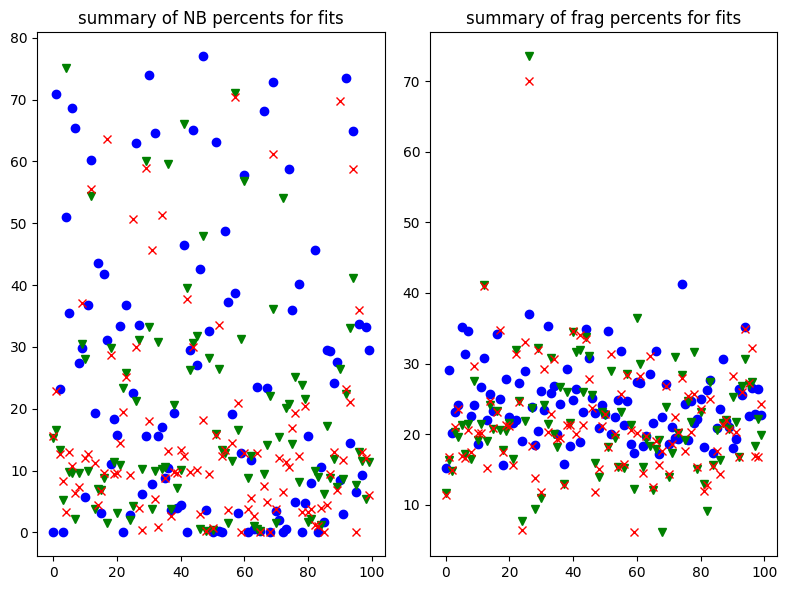

In [69]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.plot(all_rmse, "o", color="b", label="curve fit")
plt.plot(anneal_rmse, "v", color="green", label="annealing")
plt.plot(pso_rmse, "x", color="r", label="particle swarm")
plt.title("summary of RMSE for fits")
plt.legend(loc="upper left")

plt.subplot(1,3,2)
plt.plot(all_chi_sq, "o", color='b', label="curve fit")
plt.plot(anneal_chi_sq, "v", color='green', label="annealing")
plt.plot(pso_chi_sq, "x", color="r", label="particle swarm")
# plt.yscale('log')
plt.title("chi^2 values")

plt.subplot(1,3,3)
plt.plot(all_perc_QC, "o", color="b", label="curve fit")
plt.plot(anneal_perc_QC, "v", color="green", label="annealing")
plt.plot(pso_perc_QC, "x", color="r", label="particle swarm")
plt.title("summary of QC percents for fits")
#plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.plot(all_perc_NB, "o", color="b", label="curve fit")
plt.plot(anneal_perc_NB, "v", color="green", label="annealing")
plt.plot(pso_perc_NB, "x", color="r", label="particle swarm")
plt.title("summary of NB percents for fits")
#plt.legend()

plt.subplot(1,2,2)
plt.plot(all_perc_frags, "o", color="b", label="curve fit")
plt.plot(anneal_perc_frag, "v", color="green", label="annealing")
plt.plot(pso_perc_frag, "x", color="r", label="particle swarm")
plt.title("summary of frag percents for fits")
#plt.legend()
plt.tight_layout()
plt.show()



In [244]:
pso_chi_sq

array([0.16001576, 0.16205512, 0.16120188, 0.16583655, 0.16394982,
       0.16340314, 0.167433  , 0.16016013, 0.26983242, 0.16253453,
       0.15975817, 0.15836673, 0.16249899, 0.16112889, 0.16322345,
       0.1670963 , 0.16198754, 0.16913511, 0.15950806, 0.16454753,
       0.16395914, 0.15924717, 0.16324227, 0.27510339, 0.26797605,
       0.16617948, 0.16406429, 0.05596142, 0.05639299, 0.16444752,
       0.16562518, 0.16140481, 0.16693475, 0.17050527, 0.15906164,
       0.16431116, 0.16261929, 0.16259067, 0.16508281, 0.1636732 ,
       0.15967692, 0.0559775 , 0.16076999, 0.16299378, 0.16719404,
       0.16182996, 0.16400736, 0.16188436, 0.16452754, 0.16530166,
       0.16672652, 0.16084908, 0.16390662, 0.15915663, 0.16337422,
       0.16573718, 0.16663374, 0.16932469, 0.16969099, 0.15877635,
       0.16516143, 0.16400223, 0.16722221, 0.16215663, 0.16660935,
       0.16685137, 0.16254599, 0.16238411, 0.16483589, 0.16139177,
       0.16365429, 0.27385188, 0.16461249, 0.16627805, 0.16066

(100, 412)


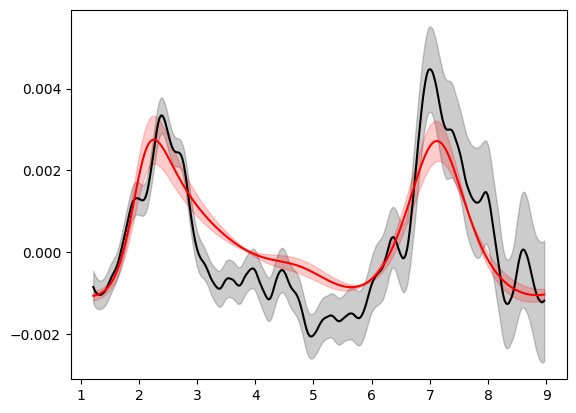

 percent QC = 30.046676121992398 +/- 26.863315361663748 
 percent NBD = 48.12769200963532 +/- 25.12037049726148       
 percent fragments = 21.825631868372277 +/- 4.20839696589242
RMSE = 0.0001477908870666494


In [74]:
matlab_fits = fit_params['dI_I_end_array']
print(matlab_fits.shape)
perc_QC_mat = fit_params['perc_QD_array']
std_perc_QC_mat = np.std(fit_params['perc_QD_array'])
perc_NB_mat = fit_params['perc_NB_array']
std_perc_NB_mat = np.std(fit_params['perc_NB_array'])
perc_frags_mat = fit_params['perc_frag_array']
std_perc_frags_mat = np.std(fit_params['perc_frag_array'])

ave_mat_fit = np.mean(matlab_fits, axis=0)[50:370]/100
std_mat_fit = np.std(matlab_fits, axis=0)[50:370]/100



plt.figure()
plt.plot(x_data, ave_exp, color='k', label="experiment")
plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_mat_fit, color='r', label='fit')
plt.fill_between(x_data, ave_mat_fit-std_mat_fit, ave_mat_fit+std_mat_fit, color='r', alpha=0.2)
plt.show()

print(f" percent QC = {np.mean(perc_QC_mat)*100} +/- {std_perc_QC_mat*100} \n percent NBD = {np.mean(perc_NB_mat)*100} +/- {std_perc_NB_mat*100} \
      \n percent fragments = {np.mean(perc_frags_mat)*100} +/- {std_perc_frags_mat*100}")

rmse = np.sqrt(np.nanmean(ave_exp-ave_mat_fit)**2)
print(f"RMSE = {rmse}")

In [144]:


def model(x, a, b, c):
    fit_result = a*(QC_late_resampled[40:]) + b*(NB_late_resampled[40:]) + c*(frag_simu[40:])
    return fit_result


def cost_func(params):
    return np.sum((y_data-model(x_data, *params))**2)

y_data = np.nanmean(late_data, axis=1)[40:]
bounds = ([0, 0, 0], [100, 100, 100])
#Fit the data using curve_fit
popt, pcov = curve_fit(model, x_data, y_data, bounds=bounds)

bounds = [(0,100), (0,100), (0,100)]
result = dual_annealing(cost_func, bounds=bounds)
sa_params = result.x

print("curve_fit parameters:", popt)
print("Simulated Annealing parameters:", sa_params)

curve_fit parameters: [0.00705945 0.00297953 0.00294887]
Simulated Annealing parameters: [0.00706164 0.00297815 0.00294893]


In [140]:
import numpy as np
from scipy.optimize import curve_fit, dual_annealing

# Define model function
def model_func(x, a, b):
    return a * np.exp(b * x)

# Generate data
x_data = np.linspace(0, 4, 50)
y_data = model_func(x_data, 2.5, -1.3) + np.random.normal(0, 0.2, x_data.size)

# Bounds for parameters
bounds = [(0, 5), (-5, 0)]  # (a, b) bounds

# 1. Curve fitting with curve_fit
popt, pcov = curve_fit(model_func, x_data, y_data, bounds=([0, -5], [5, 0]))

# 2. Curve fitting with simulated annealing
def cost_func(params):
    return np.sum((y_data - model_func(x_data, *params))**2)

result = dual_annealing(cost_func, bounds=bounds)
sa_params = result.x

print("curve_fit parameters:", popt)
print("Simulated Annealing parameters:", sa_params)


curve_fit parameters: [ 2.68582997 -1.38836908]
Simulated Annealing parameters: [ 2.68582783 -1.38836789]
